In [ ]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importing the dataset
import pandas as pd
df = pd.read_csv('Dataset.csv')

display(df.head())

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Dataset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Date,Day,Season,Daily_Sales,Price,Holiday_Flag,Fb_imp,Google_Clicks
0,2019-01-01,Tuesday,Winter,4818,49.40,0,8065,749
1,2019-01-02,Wednesday,Winter,1637,80.42,0,7664,715
2,2019-01-03,Thursday,Winter,2143,56.86,0,171,712
3,2019-01-04,Friday,Winter,3798,50.26,0,8867,553
4,2019-01-05,Saturday,Winter,4134,52.44,0,533,482



Inference: The Dataset consists of 8 features & 1826 samples.


In [ ]:
#Reframing the columns

df.Date=pd.to_datetime(df.Date) # Specifying the correct date format

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

# df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
#                                       8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

df.drop(['Date'], axis=1, inplace=True)#,'month'

target = 'Daily_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

,Day,Season,Daily_Sales,Price,Holiday_Flag,Fb_imp,Google_Clicks,weekday,month,year
0,Tuesday,Winter,4818,49.40,0,8065,749,1,1,2019
1,Wednesday,Winter,1637,80.42,0,7664,715,2,1,2019
2,Thursday,Winter,2143,56.86,0,171,712,3,1,2019
3,Friday,Winter,3798,50.26,0,8867,553,4,1,2019
4,Saturday,Winter,4134,52.44,0,533,482,5,1,2019


In [ ]:
input_file ='Dataset.csv'
data = pd.read_csv(input_file)
data.shape

(1826, 8)

In [ ]:
input_file ='Dataset.csv'
data = pd.read_csv(input_file)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1826 non-null   object 
 1   Day            1826 non-null   object 
 2   Season         1826 non-null   object 
 3   Daily_Sales    1826 non-null   int64  
 4   Price          1826 non-null   float64
 5   Holiday_Flag   1826 non-null   int64  
 6   Fb_imp         1826 non-null   int64  
 7   Google_Clicks  1826 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 114.2+ KB


In [ ]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

,0
Holiday_Flag,2
Season,4
year,5
Day,7
weekday,7
month,12
Google_Clicks,843
Daily_Sales,1524
Fb_imp,1658
Price,1746


In [ ]:
#Checking number of unique rows in each feature

# Define 'features' as a list of column names from the DataFrame 'df'
features = df.columns.tolist()  # Assuming all columns are considered features

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 6 categorical features.


In [ ]:
#Removal of any Duplicate rows

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [ ]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

               Total Null Values  Percentage
Date                           0         0.0
Day                            0         0.0
Season                         0         0.0
Daily_Sales                    0         0.0
Price                          0         0.0
Holiday_Flag                   0         0.0
Fb_imp                         0         0.0
Google_Clicks                  0         0.0


In [ ]:
#Step 9: Removal of outlier:

df1 = df.copy()

features1 = [f for f in nf if f != 'Date']

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Day,Season,Daily_Sales,Price,Holiday_Flag,Fb_imp,Google_Clicks,weekday,month,year
0,Tuesday,Winter,4818,49.40,0,8065,749,1,1,2019
1,Wednesday,Winter,1637,80.42,0,7664,715,2,1,2019
2,Thursday,Winter,2143,56.86,0,171,712,3,1,2019
3,Friday,Winter,3798,50.26,0,8867,553,4,1,2019
4,Saturday,Winter,4134,52.44,0,533,482,5,1,2019



Inference:
Before removal of outliers, The dataset had 1826 samples.
After removal of outliers, The dataset now has 1826 samples.


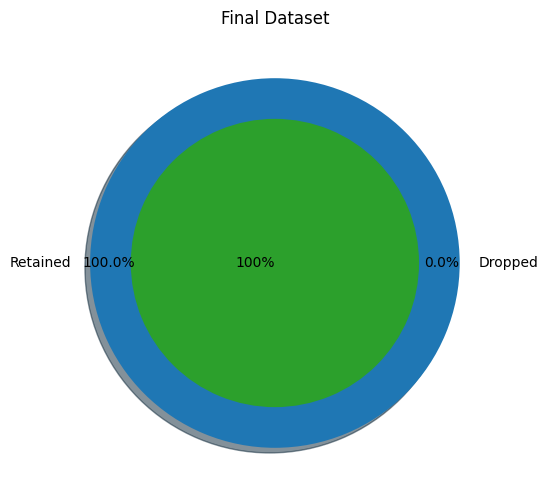


Inference: After the cleanup process, 0 samples were dropped, while retaining 0.0% of the data.


In [ ]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

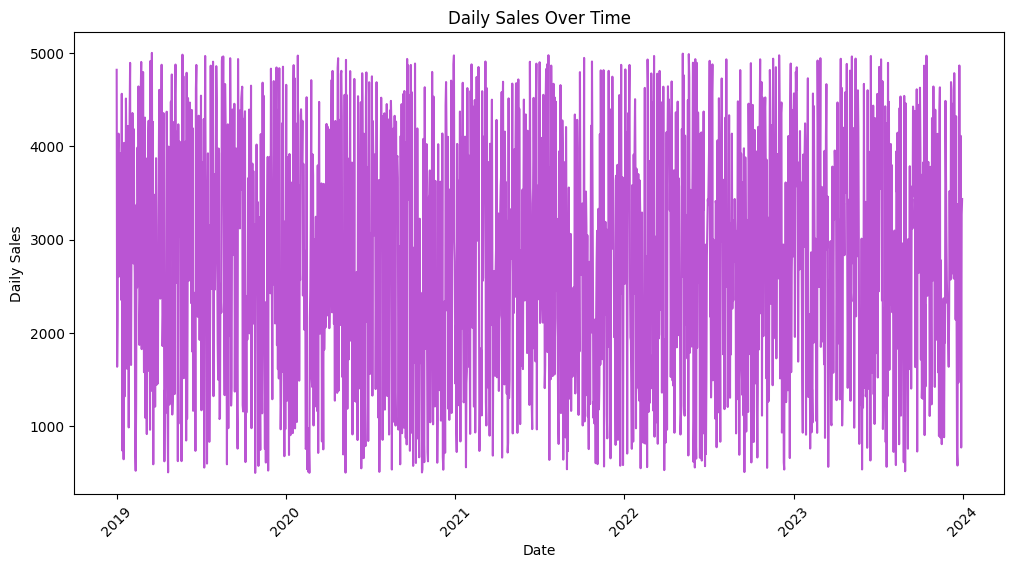

In [ ]:
#Time Series Plot
import pandas as pd
df = pd.read_csv('Dataset.csv')

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df['Date']), df['Daily_Sales'], color='#BA55D3')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Daily Sales Over Time')
plt.xticks(rotation=45)
plt.show()

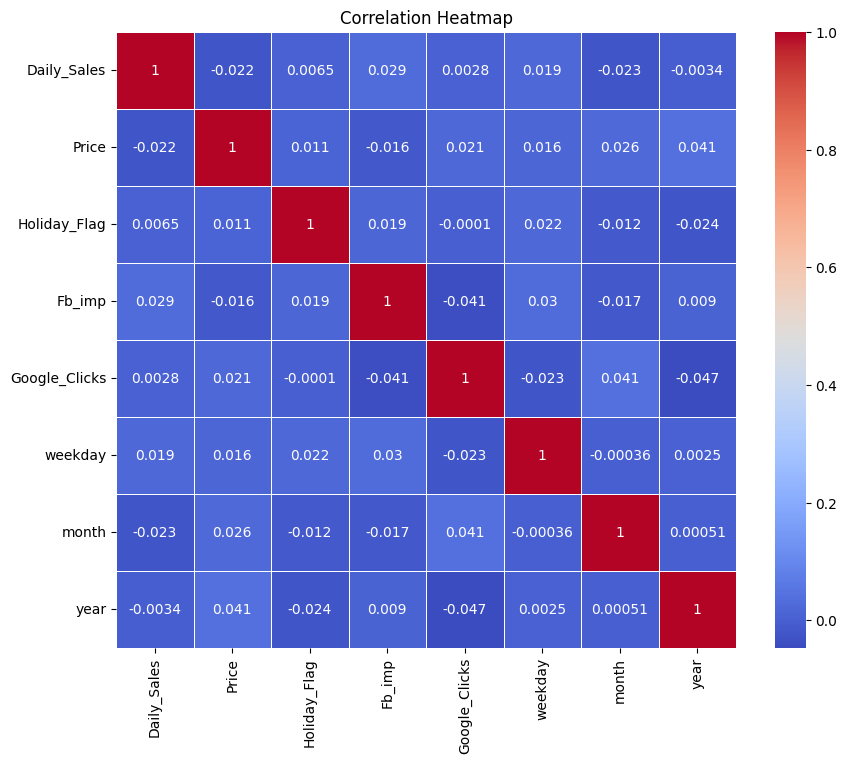

In [ ]:
#Correlation heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if 'Date' column exists, if not, skip the conversion
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])

numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

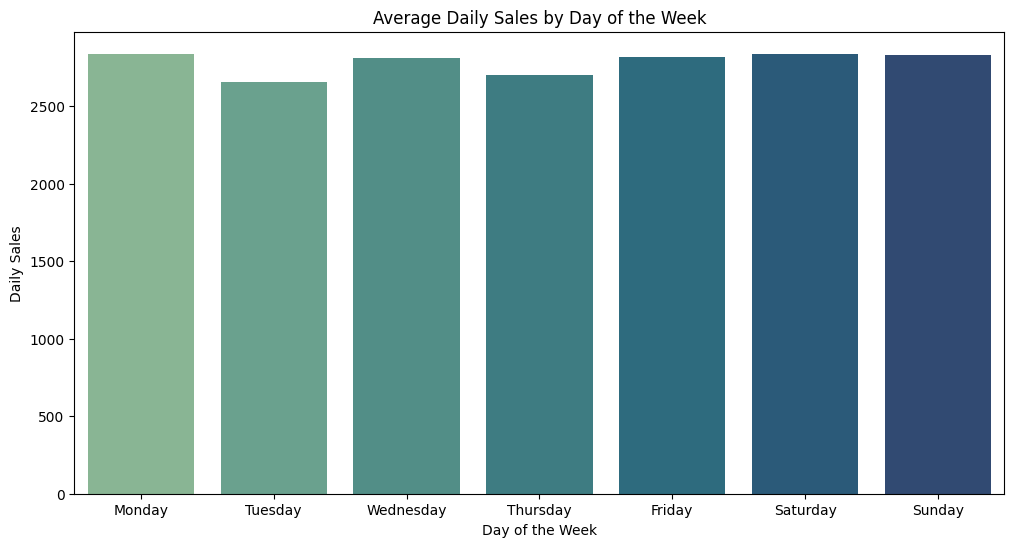

In [ ]:
#Day of the Week
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For average daily sales:
avg_sales_by_day = df.groupby('Day')['Daily_Sales'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sales_by_day.index, y=avg_sales_by_day.values, palette='crest')

plt.xlabel('Day of the Week')
plt.ylabel('Daily Sales')
plt.title('Average Daily Sales by Day of the Week')
plt.show()

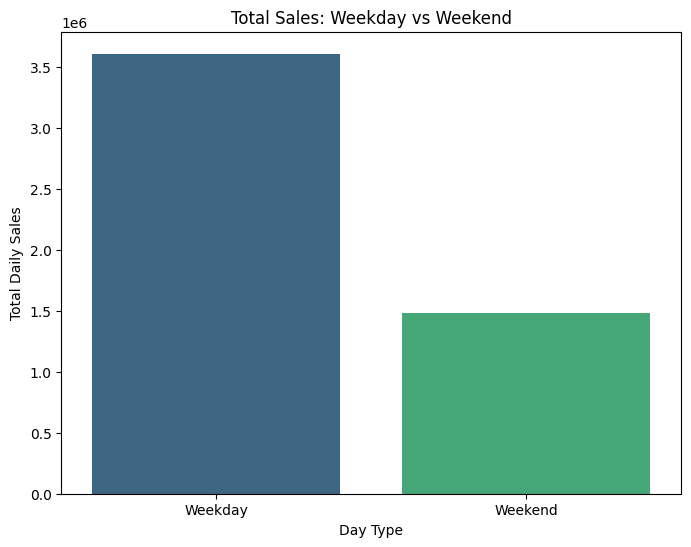

In [ ]:
#weekday vs Weekend
df['Day_Type'] = df['Day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
sales_by_day_type = df.groupby('Day_Type')['Daily_Sales'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=sales_by_day_type, x='Day_Type', y='Daily_Sales', palette="viridis")
plt.xlabel('Day Type')
plt.ylabel('Total Daily Sales')
plt.title('Total Sales: Weekday vs Weekend')
plt.show()

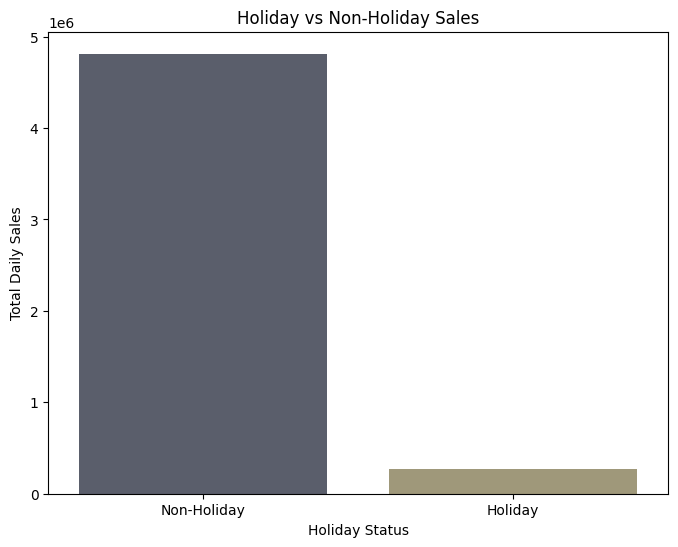

In [ ]:
#Holiday vs Non-oliday
holiday_sales = df.groupby('Holiday_Flag')['Daily_Sales'].sum().reset_index()
holiday_sales['Holiday_Flag'] = holiday_sales['Holiday_Flag'].replace({1: 'Holiday', 0: 'Non-Holiday'})

plt.figure(figsize=(8, 6))
sns.barplot(data=holiday_sales, x='Holiday_Flag', y='Daily_Sales', palette="cividis")
plt.xlabel('Holiday Status')
plt.ylabel('Total Daily Sales')
plt.title('Holiday vs Non-Holiday Sales')
plt.show()

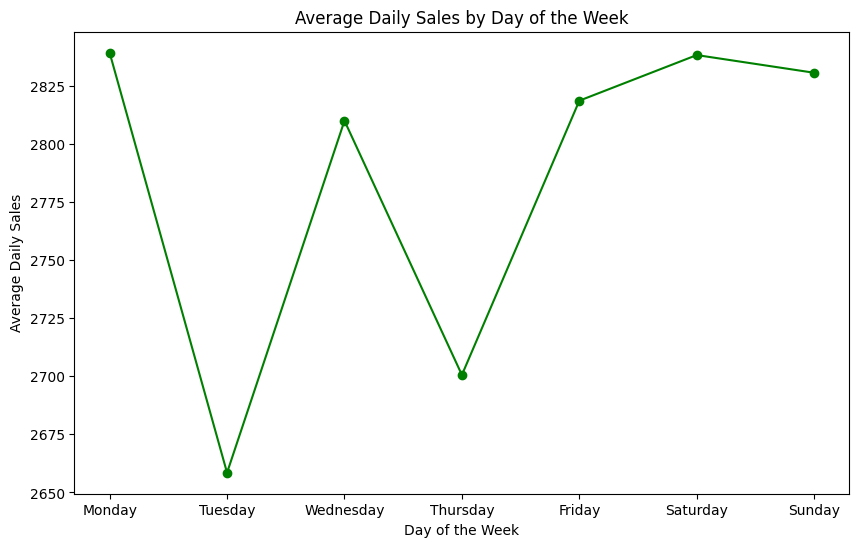

In [ ]:
#Avg Daily Sales of the week
avg_sales_by_day = df.groupby('Day')['Daily_Sales'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 6))
avg_sales_by_day.plot(kind='line', marker='o', color='green')
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Sales')
plt.title('Average Daily Sales by Day of the Week')
plt.show()

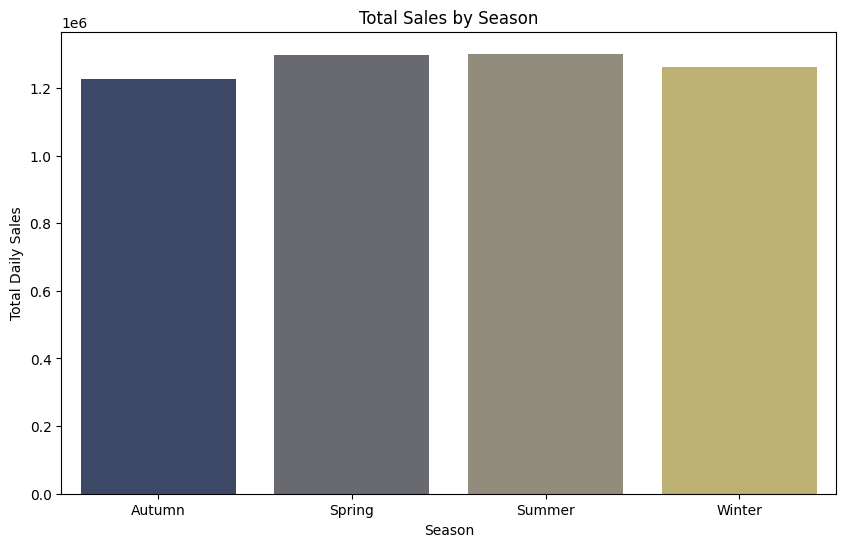

In [ ]:
#Sales by Season
seasonal_sales = df.groupby('Season')['Daily_Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_sales, x='Season', y='Daily_Sales', palette="cividis")
plt.xlabel('Season')
plt.ylabel('Total Daily Sales')
plt.title('Total Sales by Season')
plt.show()

<ipython-input-16-0e4a07524a0d>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Daily_Sales', data=monthly_sales, order=month_order, palette='cividis')


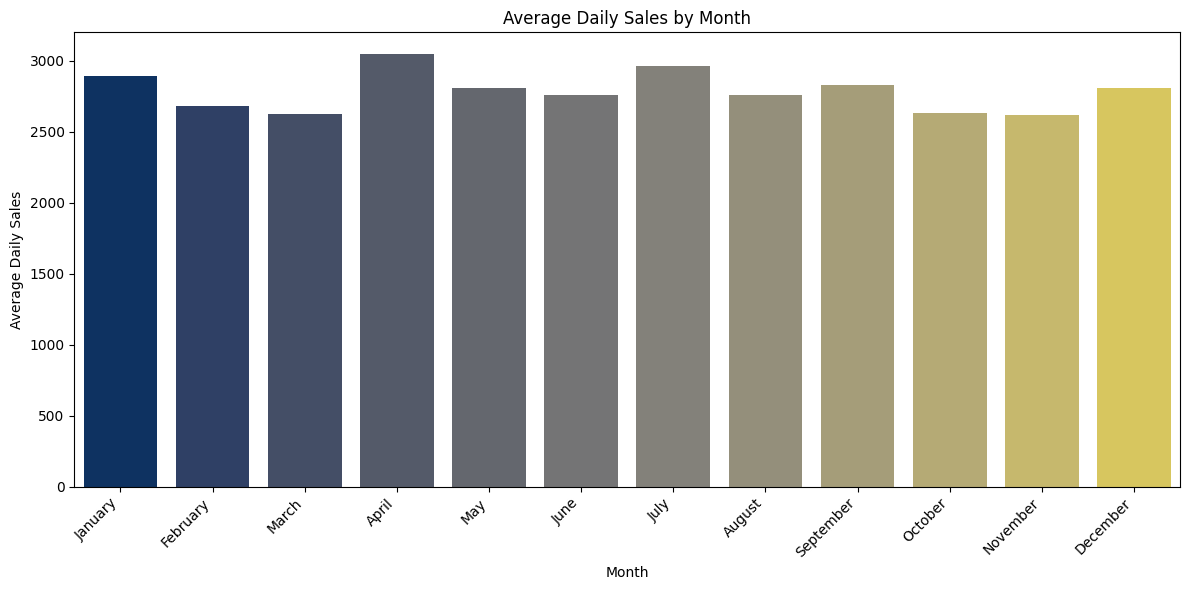

In [16]:
#Sales by Month
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_daily_sales_by_month(Dataset_df):
    # Assuming 'Date' column contains dates and 'Daily_Sales' contains sales data
    Dataset_df['Date'] = pd.to_datetime(Dataset_df['Date'])
    Dataset_df['Month'] = Dataset_df['Date'].dt.month_name()  # Extract month name

    # Group by month and calculate average daily sales
    monthly_sales = Dataset_df.groupby('Month')['Daily_Sales'].mean().reset_index()

    # Define the order of months for the x-axis
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Create the bar plot using seaborn
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    sns.barplot(x='Month', y='Daily_Sales', data=monthly_sales, order=month_order, palette='cividis')

    # Set plot labels and title
    plt.xlabel('Month')
    plt.ylabel('Average Daily Sales')
    plt.title('Average Daily Sales by Month')

    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_daily_sales_by_month(data)

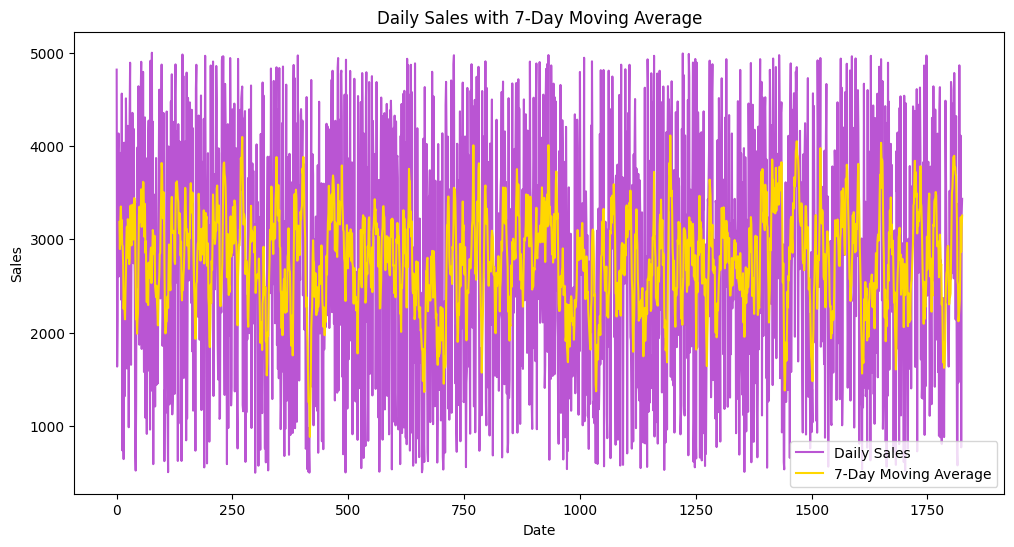

In [ ]:
#Daily Sales with 7-day moving Avg
if 'Date' not in df.columns:
    df['Date'] = df.index  # or create a suitable Date column if needed

df['Moving_Avg'] = df['Daily_Sales'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Daily_Sales'], color='#BA55D3', label='Daily Sales')
plt.plot(df['Date'], df['Moving_Avg'], color='#FFD700', label='7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales with 7-Day Moving Average')
plt.legend()
plt.show()

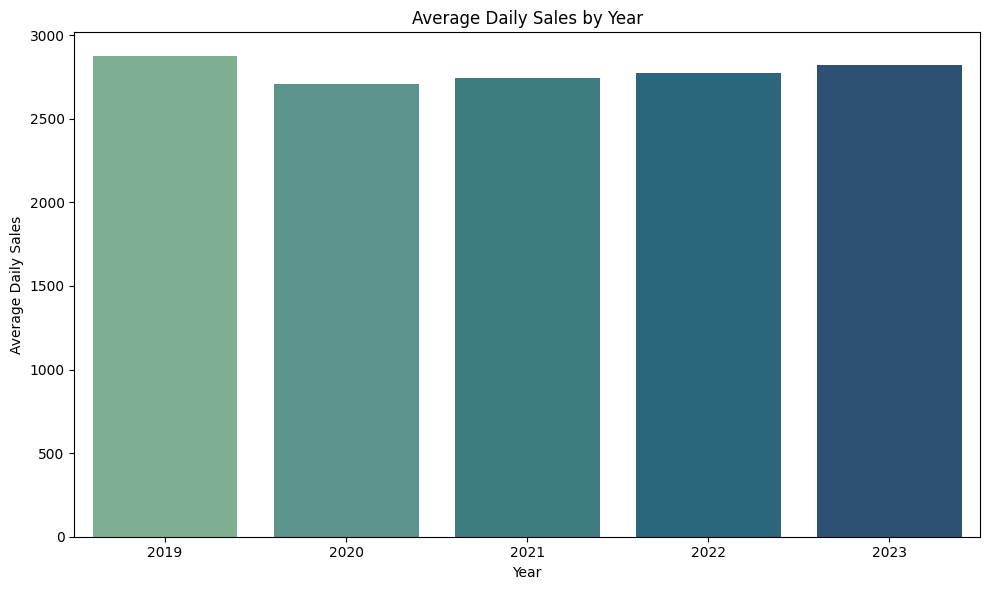

In [ ]:
#Sales by Year
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_daily_sales_by_year(Dataset_df):
    # Assuming 'Date' column contains dates and 'Daily_Sales' contains sales data
    Dataset_df['Date'] = pd.to_datetime(Dataset_df['Date'])
    Dataset_df['Year'] = Dataset_df['Date'].dt.year  # Extract year

    # Group by year and calculate average daily sales
    yearly_sales = Dataset_df.groupby('Year')['Daily_Sales'].mean().reset_index()

    # Create the bar plot using seaborn
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.barplot(x='Year', y='Daily_Sales', data=yearly_sales, palette='crest')

    # Set plot labels and title
    plt.xlabel('Year')
    plt.ylabel('Average Daily Sales')
    plt.title('Average Daily Sales by Year')

    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_daily_sales_by_year(data)

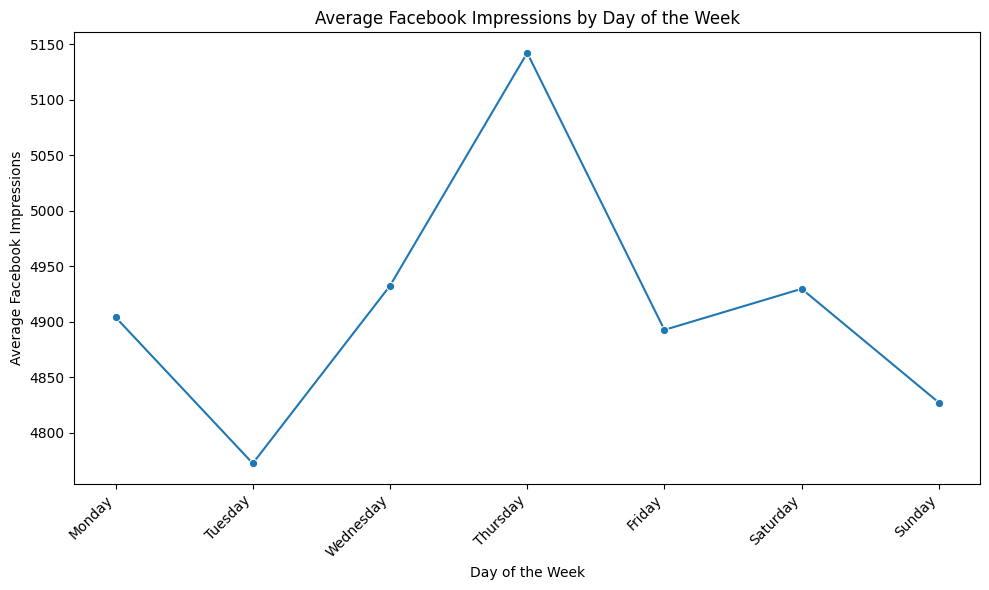

In [ ]:
#Impression by day of week
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_fb_imp_by_day_lineplot(Dataset_df):
    # Assuming 'Date' column contains dates and 'Fb_imp' contains impression data
    Dataset_df['Date'] = pd.to_datetime(Dataset_df['Date'])
    Dataset_df['DayofWeek'] = Dataset_df['Date'].dt.day_name()

    # Group by day of the week and calculate average Facebook impressions
    daily_impressions = Dataset_df.groupby('DayofWeek')['Fb_imp'].mean().reset_index()

    # Define the order of days for the x-axis
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create the line plot using seaborn
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.lineplot(x='DayofWeek', y='Fb_imp', data=daily_impressions, marker='o')

    # Set plot labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Facebook Impressions')
    plt.title('Average Facebook Impressions by Day of the Week')

    # Reorder x-axis using 'day_order' for categorical plotting after the lineplot is generated
    plt.xticks(range(len(day_order)), day_order, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_fb_imp_by_day_lineplot(data)

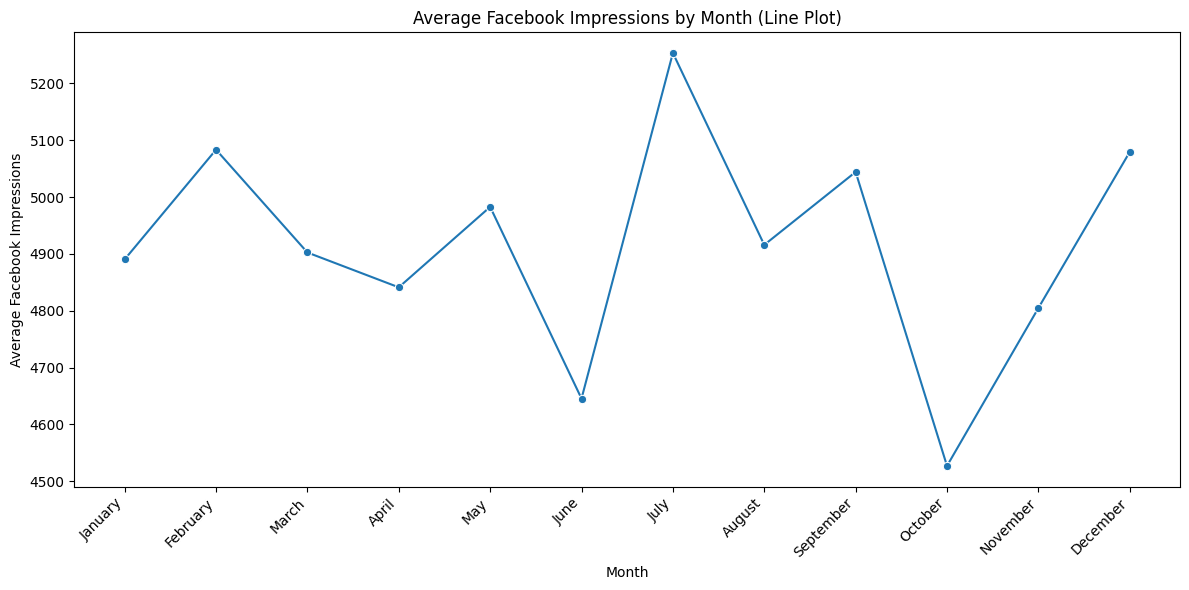

In [ ]:
#Impression by month
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_fb_imp_by_month_lineplot(Dataset_df):
    Dataset_df['Date'] = pd.to_datetime(Dataset_df['Date'])
    Dataset_df['Month'] = Dataset_df['Date'].dt.month_name()
    monthly_impressions = Dataset_df.groupby('Month')['Fb_imp'].mean().reset_index()

    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Month', y='Fb_imp', data=monthly_impressions, marker='o')
    plt.xlabel('Month')
    plt.ylabel('Average Facebook Impressions')
    plt.title('Average Facebook Impressions by Month (Line Plot)')
    plt.xticks(range(len(month_order)), month_order, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_fb_imp_by_month_lineplot(data)

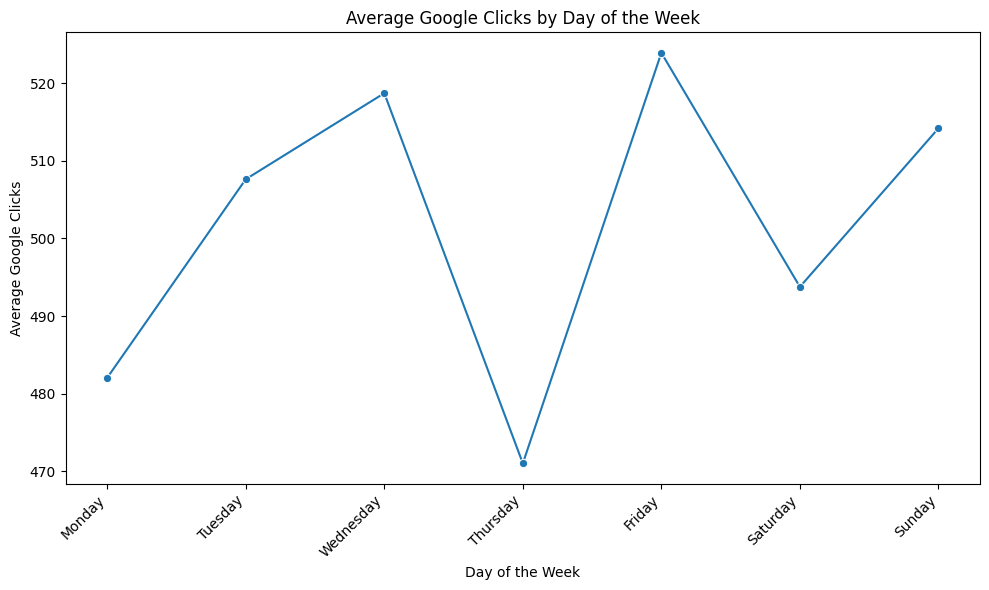

In [ ]:
#Clicks by day of week
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_google_clicks_by_day_lineplot(Dataset_df):
    # Assuming 'Date' column contains dates and 'Google_Clicks' contains click data
    Dataset_df['Date'] = pd.to_datetime(Dataset_df['Date'])
    Dataset_df['DayofWeek'] = Dataset_df['Date'].dt.day_name()

    # Group by day of the week and calculate average Google clicks
    daily_clicks = Dataset_df.groupby('DayofWeek')['Google_Clicks'].mean().reset_index()

    # Define the order of days for the x-axis
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create the line plot using seaborn
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.lineplot(x='DayofWeek', y='Google_Clicks', data=daily_clicks, marker='o')

    # Set plot labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Google Clicks')
    plt.title('Average Google Clicks by Day of the Week')

    # Reorder x-axis using 'day_order' for categorical plotting after the lineplot is generated
    plt.xticks(range(len(day_order)), day_order, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_google_clicks_by_day_lineplot(data)

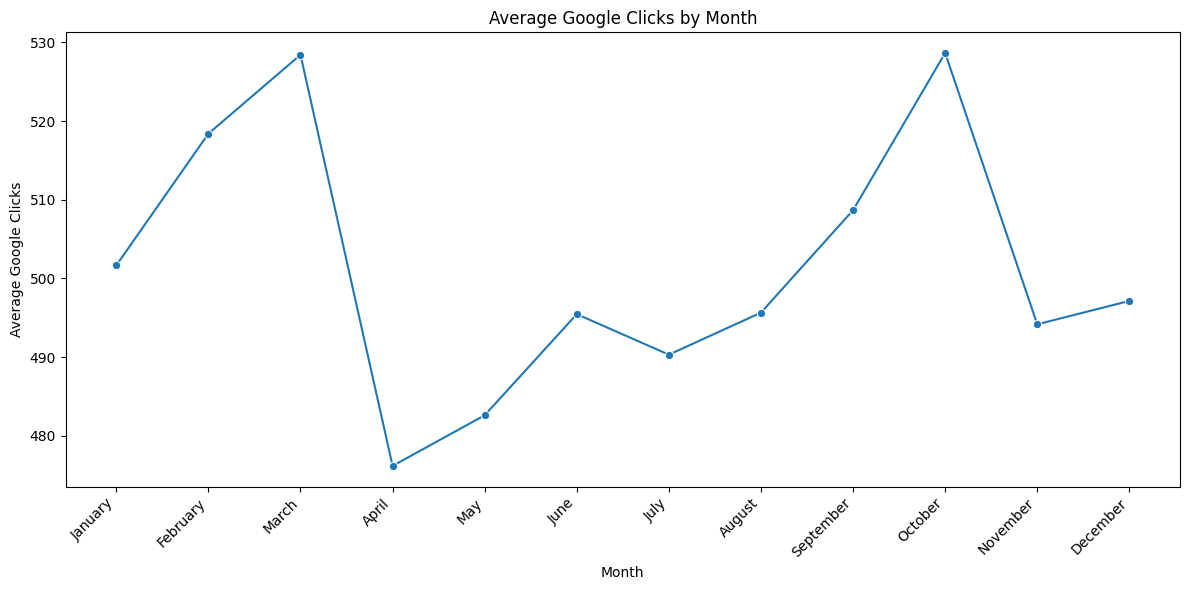

In [ ]:
#Clicks by month
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_google_clicks_by_month_lineplot(Dataset_df):
    # Assuming 'Date' column contains dates and 'Google_Clicks' contains click data
    Dataset_df['Date'] = pd.to_datetime(Dataset_df['Date'])
    Dataset_df['Month'] = Dataset_df['Date'].dt.month_name()  # Extract month name

    # Group by month and calculate average Google clicks
    monthly_clicks = Dataset_df.groupby('Month')['Google_Clicks'].mean().reset_index()

    # Define the order of months for the x-axis
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']

    # --- The 'order' parameter is removed here ---
    # Create the line plot using seaborn
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    sns.lineplot(x='Month', y='Google_Clicks', data=monthly_clicks, marker='o')


    # Set plot labels and title
    plt.xlabel('Month')
    plt.ylabel('Average Google Clicks')
    plt.title('Average Google Clicks by Month')

    # Reorder x-axis using 'month_order' for categorical plotting after the lineplot is generated
    plt.xticks(range(len(month_order)), month_order, rotation=45, ha='right')


    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_google_clicks_by_month_lineplot(data)

                            OLS Regression Results                            
Dep. Variable:            Daily_Sales   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.576
Date:                Wed, 30 Oct 2024   Prob (F-statistic):              0.210
Time:                        12:23:31   Log-Likelihood:                -15669.
No. Observations:                1826   AIC:                         3.134e+04
Df Residuals:                    1824   BIC:                         3.135e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2720.2728     59.754     45.524      0.0

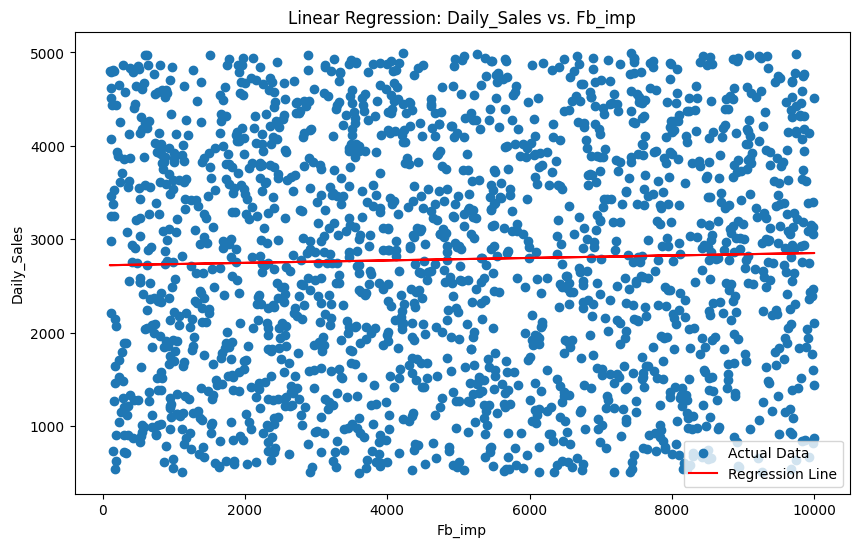

In [ ]:
#Linear regression
#Sales vs Impression
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

def linear_regression_with_plotting(Dataset_df, dependent_variable, independent_variables):

    # Build the regression formula string
    formula = f"{dependent_variable} ~ {' + '.join(independent_variables)}"

    # Create and fit the OLS model
    model = sm.ols(formula=formula, data=Dataset_df)
    results = model.fit()

    # Print the regression summary
    print(results.summary())

    # Get predicted values
    y_pred = results.predict(Dataset_df)

    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(Dataset_df[independent_variables[0]], Dataset_df[dependent_variable], label="Actual Data")
    plt.plot(Dataset_df[independent_variables[0]], y_pred, color='red', label="Regression Line")
    plt.xlabel(independent_variables[0])
    plt.ylabel(dependent_variable)
    plt.title(f"Linear Regression: {dependent_variable} vs. {independent_variables[0]}")
    plt.legend()
    plt.show()

# Example usage:
# Assuming 'data' is your DataFrame and you want to predict 'Daily_Sales'
# based on 'Fb_imp'
linear_regression_with_plotting(data, 'Daily_Sales', ['Fb_imp'])

                            OLS Regression Results                            
Dep. Variable:            Daily_Sales   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01432
Date:                Wed, 30 Oct 2024   Prob (F-statistic):              0.905
Time:                        12:45:07   Log-Likelihood:                -15669.
No. Observations:                1826   AIC:                         3.134e+04
Df Residuals:                    1824   BIC:                         3.135e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2778.6401     61.204     45.399

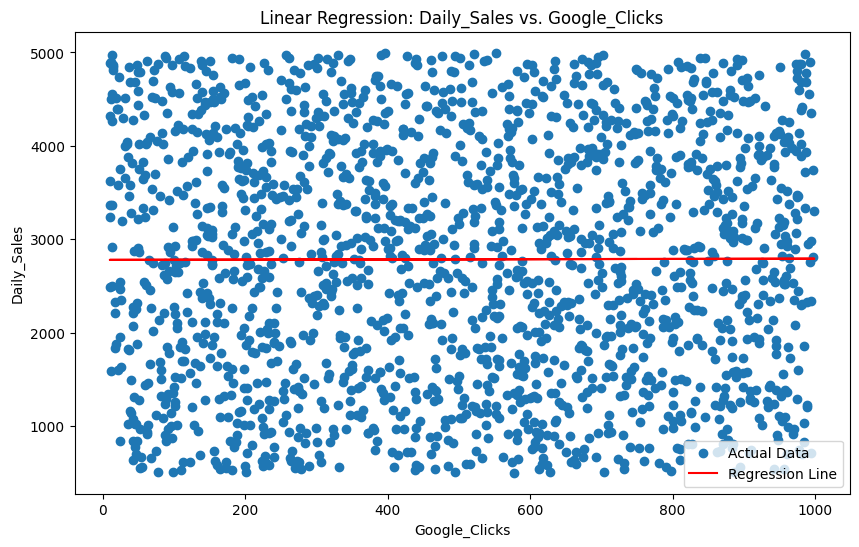

In [ ]:
#Linear regression
#Sales vs Clicks
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

def linear_regression_with_google_clicks(Dataset_df):

    # Build the regression formula string
    formula = "Daily_Sales ~ Google_Clicks"

    # Create and fit the OLS model
    model = sm.ols(formula=formula, data=Dataset_df)
    results = model.fit()

    # Print the regression summary
    print(results.summary())

    # Get predicted values
    y_pred = results.predict(Dataset_df)

    # Create scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(Dataset_df['Google_Clicks'], Dataset_df['Daily_Sales'], label="Actual Data")
    plt.plot(Dataset_df['Google_Clicks'], y_pred, color='red', label="Regression Line")
    plt.xlabel("Google_Clicks")
    plt.ylabel("Daily_Sales")
    plt.title("Linear Regression: Daily_Sales vs. Google_Clicks")
    plt.legend()
    plt.show()

    return results

# Example usage:
# Assuming 'data' is your DataFrame
results = linear_regression_with_google_clicks(data)

Linear Regression - RMSE: 1252.37
Linear Regression - MAE: 1078.93


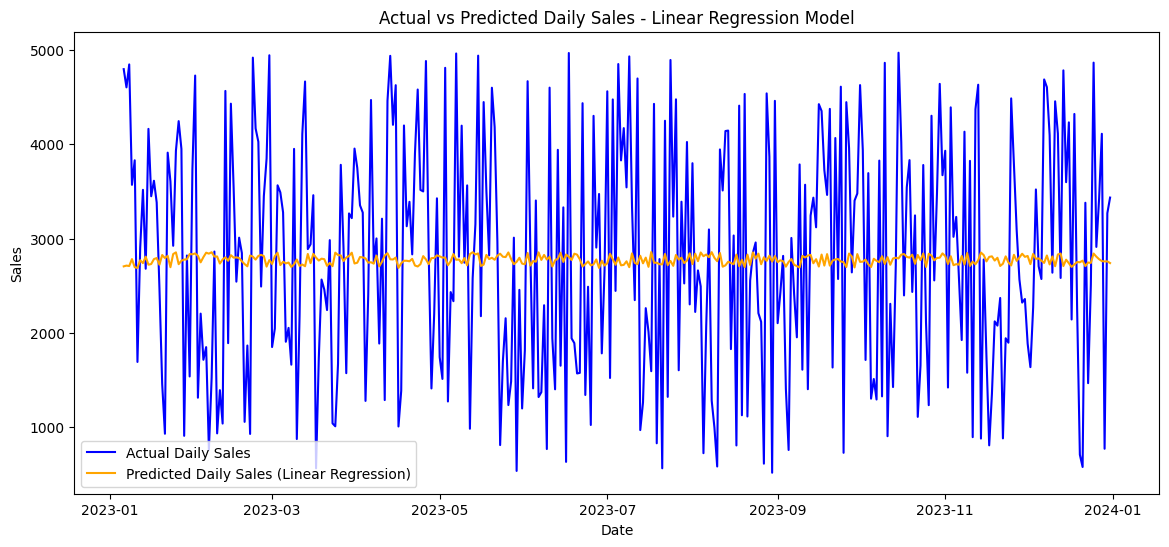

In [ ]:
#Linear regression
#Actual vs Predicted Sales
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess dataset
df = pd.read_csv('Dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
df['Lag_1'] = df['Daily_Sales'].shift(1)
df['Lag_7'] = df['Daily_Sales'].shift(7)
df['Lag_30'] = df['Daily_Sales'].shift(30)

# Drop NaN values created by shifting
df.dropna(inplace=True)

# Split data into features and target
X = df[['Lag_1', 'Lag_7', 'Lag_30']]
y = df['Daily_Sales']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f'Linear Regression - RMSE: {rmse_lr:.2f}')
print(f'Linear Regression - MAE: {mae_lr:.2f}')

# Plotting the actual vs. predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Daily Sales', color='blue')
plt.plot(y_test.index, y_pred_lr, label='Predicted Daily Sales (Linear Regression)', color='orange')
plt.title('Actual vs Predicted Daily Sales - Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Day            1826 non-null   object 
 1   Season         1826 non-null   object 
 2   Daily_Sales    1826 non-null   int64  
 3   Price          1826 non-null   float64
 4   Holiday_Flag   1826 non-null   int64  
 5   Fb_imp         1826 non-null   int64  
 6   Google_Clicks  1826 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 114.1+ KB
None
       Daily_Sales        Price  Holiday_Flag       Fb_imp  Google_Clicks
count  1826.000000  1826.000000   1826.000000  1826.000000    1826.000000
mean   2785.009310   110.005323      0.053122  4914.503834     501.595838
std    1290.232061    52.234382      0.224337  2877.870806     284.657620
min     500.000000    20.200000      0.000000   102.000000      10.000000
25%    1652.750000    63.777500      0.00

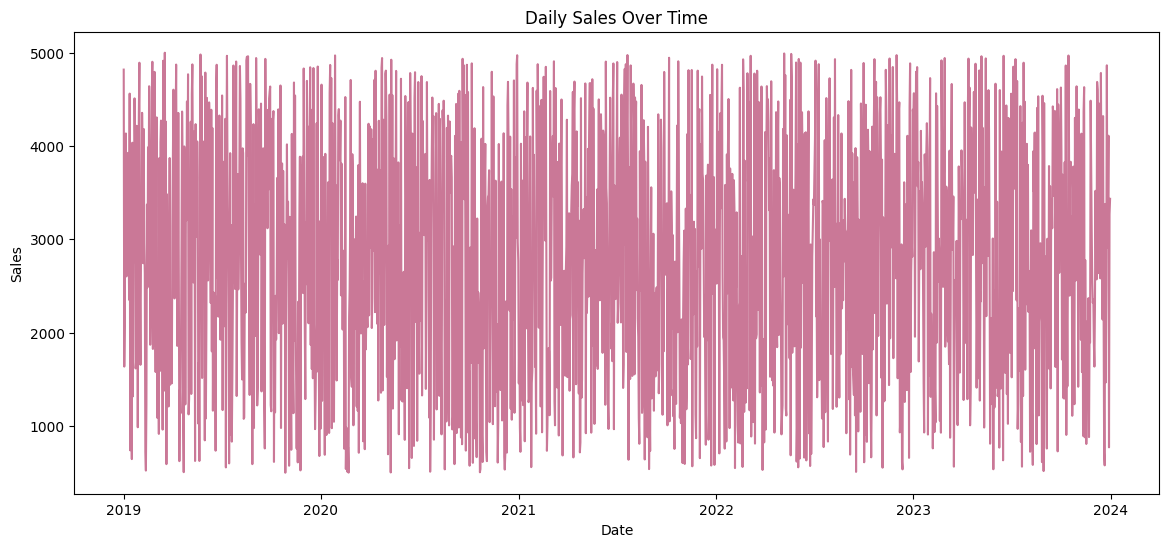

In [ ]:
#Daily Sales over time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv('Dataset.csv')

# Convert Date column to datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display basic information
print(df.info())
print(df.describe())

# Plot Daily Sales over time
plt.figure(figsize=(14, 6))
plt.plot(df['Daily_Sales'], color='#CA7897')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


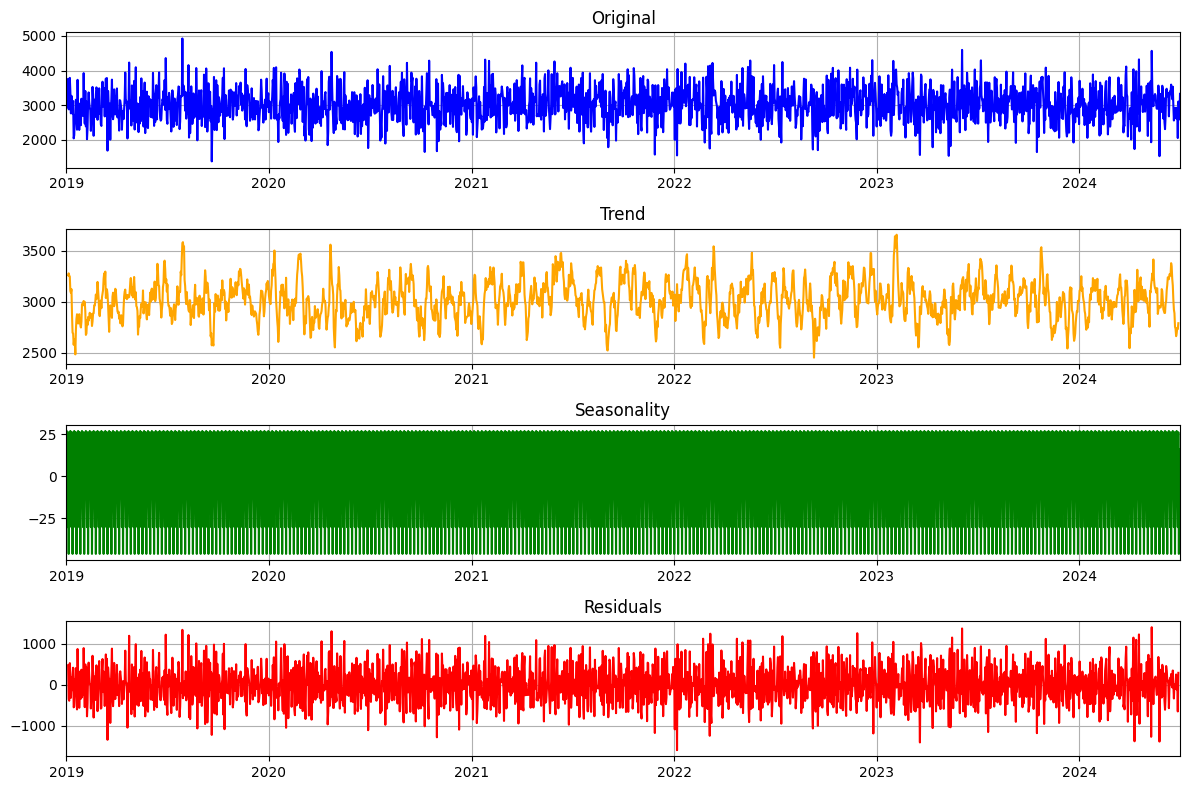

In [ ]:
#Seasonal decomposition
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Sample time series data generation (replace with your dataset)
np.random.seed(42)
date_rng = pd.date_range(start='2019-01-01', end='2024-07-01', freq='D')
data = np.random.normal(loc=3000, scale=500, size=len(date_rng))

# Create DataFrame
df = pd.DataFrame(data, index=date_rng, columns=['Original'])

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df['Original'], model='additive')

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['Original'], color='blue')
plt.title('Original')
plt.xlim(df.index[0], df.index[-1])
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, color='orange')
plt.title('Trend')
plt.xlim(df.index[0], df.index[-1])
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, color='green')
plt.title('Seasonality')
plt.xlim(df.index[0], df.index[-1])
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, color='red')
plt.title('Residuals')
plt.xlim(df.index[0], df.index[-1])
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# ADF Test
adf_test = adfuller(df['Daily_Sales'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -28.649756405604016
p-value: 0.0


In [ ]:
# ADF Test
def load_data(data):
    return pd.read_csv(data)
def adf_test(timeseries, series_name):
    adf_statistic, p_value, *_ = adfuller(timeseries.dropna(), autolag='AIC')
    print(f"\nADF Test for {series_name}:\n ADF Statistic: {adf_statistic}\n p-value: {p_value}")
    print(f"{series_name} is {'stationary.' if p_value < 0.05 else 'non-stationary.'}\n")
def main():
    df = load_data('Dataset.csv')
    for column in ['Daily_Sales','Google_Clicks', 'Fb_imp']:
        adf_test(df[column], column)
if __name__ == "__main__":
    main()


ADF Test for Daily_Sales:
 ADF Statistic: -28.649756405604016
 p-value: 0.0
Daily_Sales is stationary.


ADF Test for Google_Clicks:
 ADF Statistic: -43.80330422142327
 p-value: 0.0
Google_Clicks is stationary.


ADF Test for Fb_imp:
 ADF Statistic: -24.987506764506485
 p-value: 0.0
Fb_imp is stationary.



In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
adf_test = adfuller(df['Daily_Sales'].dropna())

# Print ADF test results
print('ADF Test Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

ADF Test Statistic: -28.649756405604016
p-value: 0.0
Critical Values:
   1%: -3.433940201056092
   5%: -2.8631258735235106
   10%: -2.5676142653629


ADF Statistic for Daily_Sales: -28.649756405604016
p-value for Daily_Sales: 0.0
Number of lags used for Daily_Sales: 1
Daily_Sales is stationary.



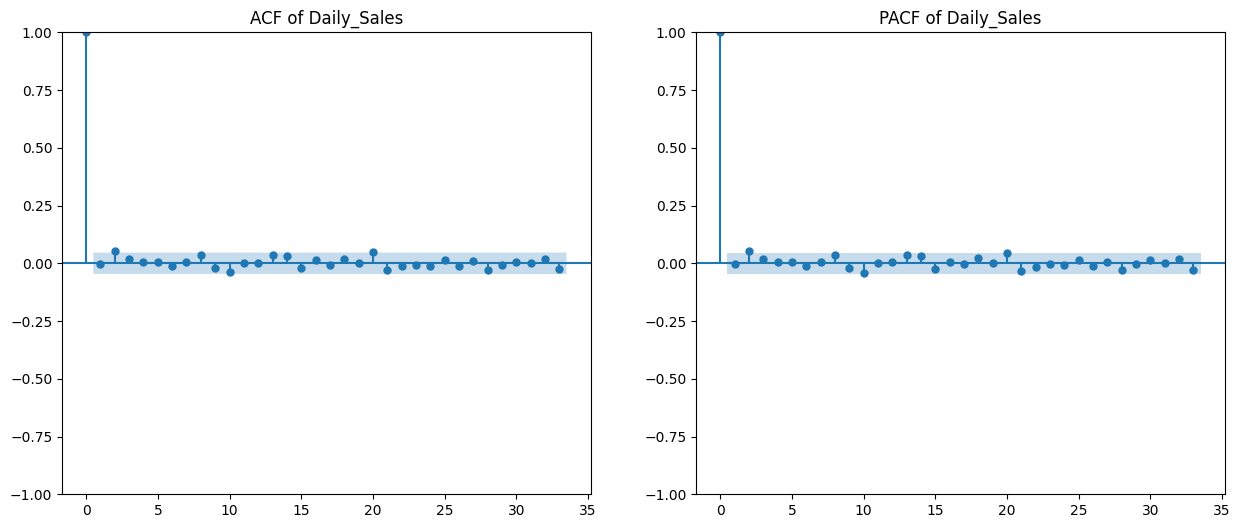

In [ ]:
#ACF vs PACF
import pandas as pd
from statsmodels.tsa.stattools import adfuller # Import adfuller function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import plotting functions for ACF and PACF
import matplotlib.pyplot as plt

data = pd.read_csv('Dataset.csv')
def analyze_series(series, name, lags=None):
    if lags is not None:
        result = adfuller(series, maxlag=lags)
    else:
        result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value for {name}: {result[1]}')
    print(f'Number of lags used for {name}: {result[2]}')
    print(f'{name} is {"stationary." if result[1] < 0.05 else "non-stationary."}\n')
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(series, ax=axes[0])
    plot_pacf(series, ax=axes[1])
    axes[0].set_title(f'ACF of {name}')
    axes[1].set_title(f'PACF of {name}')
    plt.show()
for column in ['Daily_Sales']:
    if column == 'Daily_Sales':
        analyze_series(data[column], column, lags=1)
    else:
        analyze_series(data[column], column)

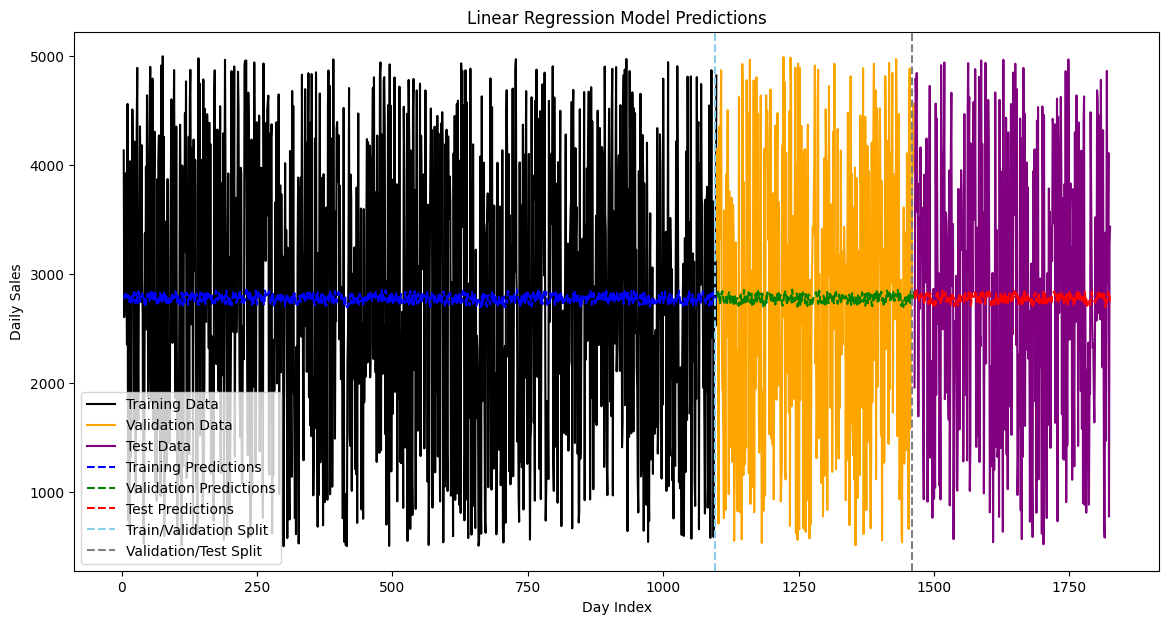

Validation Set Metrics for Linear Regression:
MSE: 1752778.35
RMSE: 1323.93
MAE: 1157.61
MAPE: 69.37%
R²: -0.00
Adjusted R²: -0.00
Test Set Metrics for Linear Regression:
MSE: 1533158.77
RMSE: 1238.21
MAE: 1067.32
MAPE: 58.89%
R²: 0.01
Adjusted R²: 0.01


In [ ]:
#LINEAR REGRESSION MODEL
from sklearn.linear_model import LinearRegression

# Create lagged features for Linear Regression
data['Lag_1'] = data['Daily_Sales'].shift(1)
data['Lag_2'] = data['Daily_Sales'].shift(2)

# Drop NaN rows after shifting
data = data.dropna()

# Split data into train, validation, and test sets
train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

X_train = train_data[['Lag_1', 'Lag_2']]
y_train = train_data['Daily_Sales']
X_val = val_data[['Lag_1', 'Lag_2']]
y_val = val_data['Daily_Sales']
X_test = test_data[['Lag_1', 'Lag_2']]
y_test = test_data['Daily_Sales']

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
train_pred_lr = lr_model.predict(X_train)
val_pred_lr = lr_model.predict(X_val)
test_pred_lr = lr_model.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], y_train, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], y_val, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], y_test, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred_lr) + 1], train_pred_lr, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_lr) + 1:len(train_pred_lr) + len(val_pred_lr) + 1], val_pred_lr, label='Validation Predictions', color='green', linestyle='dashed')

# Adjust the x-axis for the test predictions to match the length of test_pred_lr
plt.plot(data['Day Index'][n_train + n_val:n_train + n_val + len(test_pred_lr)], test_pred_lr, label='Test Predictions', color='red', linestyle='dashed')
# The above line is changed to ensure the x-axis and y-axis for the test data have the same length


plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')

plt.xlabel('Day Index')
plt.ylabel('Daily Sales')
plt.title('Linear Regression Model Predictions')
plt.legend()
plt.show()

# Evaluate Linear Regression
val_true = y_val.values
val_pred_lr = val_pred_lr[:len(val_true)]
val_mse_lr, val_rmse_lr, val_mae_lr, val_mape_lr, val_r2_lr, val_r2_adj_lr = evaluate(val_true, val_pred_lr)

test_true = y_test.values
test_pred_lr = test_pred_lr[:len(test_true)]
test_mse_lr, test_rmse_lr, test_mae_lr, test_mape_lr, test_r2_lr, test_r2_adj_lr = evaluate(test_true, test_pred_lr)

print(f"Validation Set Metrics for Linear Regression:\nMSE: {val_mse_lr:.2f}\nRMSE: {val_rmse_lr:.2f}\nMAE: {val_mae_lr:.2f}\nMAPE: {val_mape_lr:.2f}%\nR²: {val_r2_lr:.2f}\nAdjusted R²: {val_r2_adj_lr:.2f}")
print(f"Test Set Metrics for Linear Regression:\nMSE: {test_mse_lr:.2f}\nRMSE: {test_rmse_lr:.2f}\nMAE: {test_mae_lr:.2f}\nMAPE: {test_mape_lr:.2f}%\nR²: {test_r2_lr:.2f}\nAdjusted R²: {test_r2_adj_lr:.2f}")

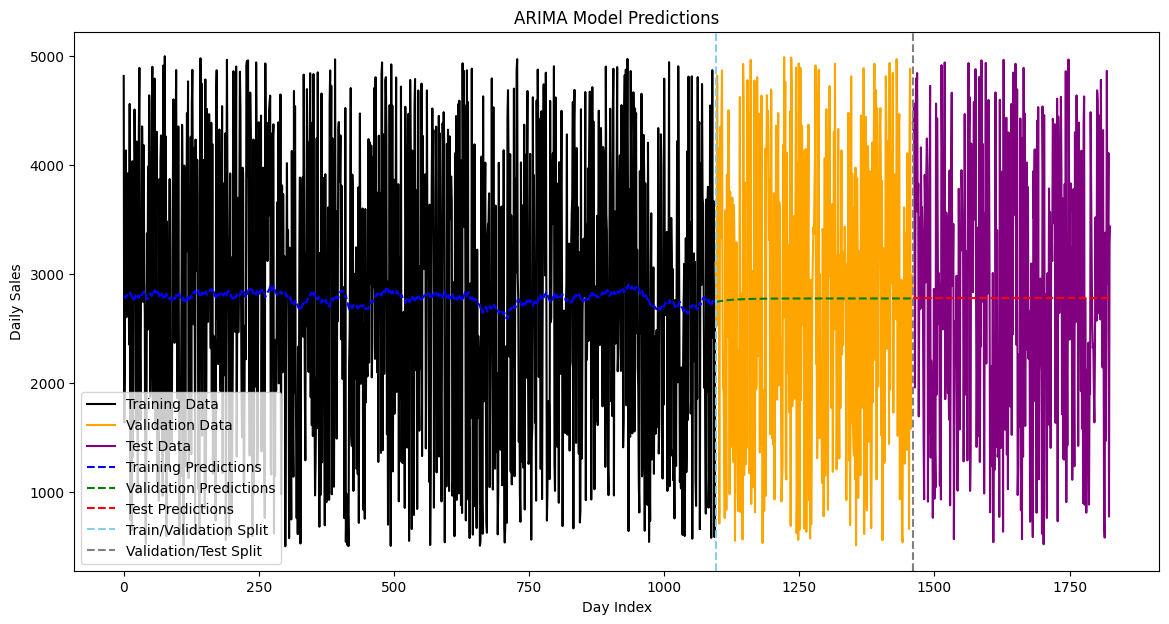

Validation Set Metrics for ARIMA:
MSE: 1737194.69
RMSE: 1318.03
MAE: 1147.09
MAPE: 69.06%
R²: -0.00
Adjusted R²: -0.00
Test Set Metrics for ARIMA:
MSE: 1557025.84
RMSE: 1247.81
MAE: 1077.93
MAPE: 58.93%
R²: -0.00
Adjusted R²: -0.00


In [ ]:
#ARIMA MODEL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and Prepare Data
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data = data[['Date', 'Daily_Sales', 'Fb_imp', 'Google_Clicks', 'Price']]
data = data.sort_values(by='Date')

# Create index column for plotting
data['Day Index'] = np.arange(len(data))

# Split data into training, validation, and test sets
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

train_sales = train_data['Daily_Sales']
val_sales = val_data['Daily_Sales']
test_sales = test_data['Daily_Sales']

# Fit ARIMA Model
arima_model = ARIMA(train_sales, order=(1, 0, 1))  # Adjust ARIMA order as needed
arima_fit = arima_model.fit()

# Predictions
train_pred_arima = arima_fit.predict(start=1, end=len(train_sales) - 1)
val_pred_arima = arima_fit.predict(start=len(train_sales), end=len(train_sales) + len(val_sales) - 1)
test_pred_arima = arima_fit.predict(start=len(train_sales) + len(val_sales), end=len(train_sales) + len(val_sales) + len(test_sales) - 1)

# Concatenate all predictions
all_pred_arima = np.concatenate([train_pred_arima, val_pred_arima, test_pred_arima])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], train_sales, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_sales, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], test_sales, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred_arima) + 1], train_pred_arima, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_arima) + 1:len(train_pred_arima) + len(val_pred_arima) + 1], val_pred_arima, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_arima) + len(val_pred_arima) + 1:], test_pred_arima, label='Test Predictions', color='red', linestyle='dashed')

# Add split markers
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')

# Customize plot
plt.xlabel('Day Index')
plt.ylabel('Daily Sales')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()

# Evaluation function
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1  # Number of predictors
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj

# Validation set metrics
val_true = val_sales.values
val_pred_arima = val_pred_arima[:len(val_true)]
val_mse_arima, val_rmse_arima, val_mae_arima, val_mape_arima, val_r2_arima, val_r2_adj_arima = evaluate(val_true, val_pred_arima)

# Test set metrics
test_true = test_sales.values
test_pred_arima = test_pred_arima[:len(test_true)]
test_mse_arima, test_rmse_arima, test_mae_arima, test_mape_arima, test_r2_arima, test_r2_adj_arima = evaluate(test_true, test_pred_arima)

# Print metrics
print(f"Validation Set Metrics for ARIMA:\nMSE: {val_mse_arima:.2f}\nRMSE: {val_rmse_arima:.2f}\nMAE: {val_mae_arima:.2f}\nMAPE: {val_mape_arima:.2f}%\nR²: {val_r2_arima:.2f}\nAdjusted R²: {val_r2_adj_arima:.2f}")
print(f"Test Set Metrics for ARIMA:\nMSE: {test_mse_arima:.2f}\nRMSE: {test_rmse_arima:.2f}\nMAE: {test_mae_arima:.2f}\nMAPE: {test_mape_arima:.2f}%\nR²: {test_r2_arima:.2f}\nAdjusted R²: {test_r2_adj_arima:.2f}")

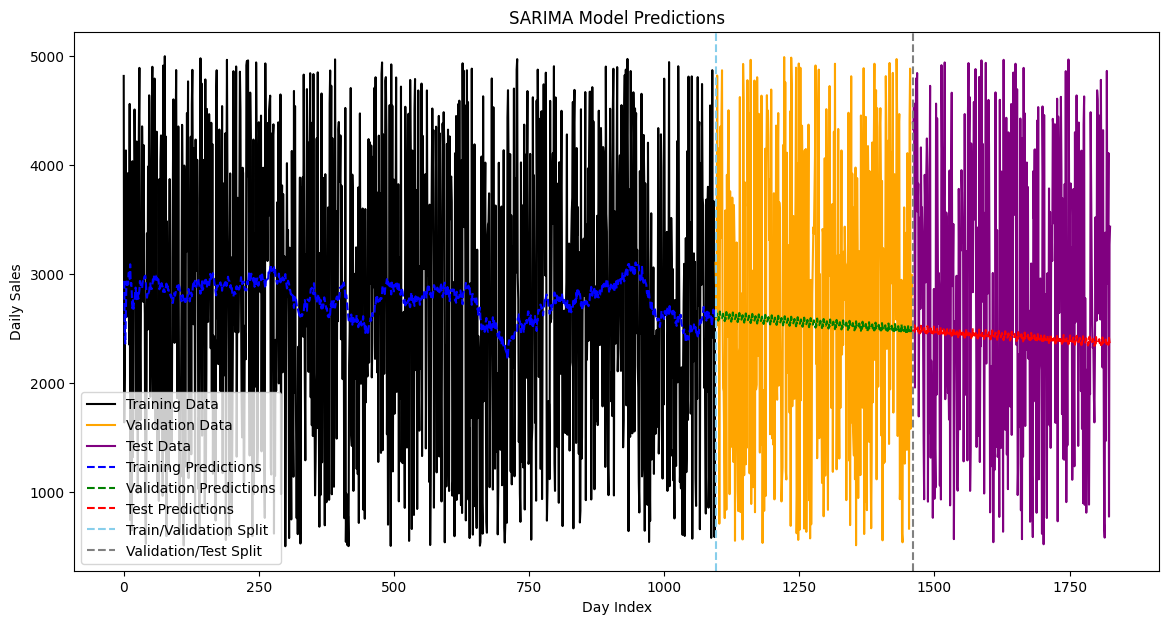

Validation Set Metrics for SARIMA:
MSE: 1799138.49
RMSE: 1341.32
MAE: 1168.24
MAPE: 64.20%
R²: -0.04
Adjusted R²: -0.04
Test Set Metrics for SARIMA:
MSE: 1717186.64
RMSE: 1310.41
MAE: 1116.57
MAPE: 52.90%
R²: -0.10
Adjusted R²: -0.11


In [ ]:
#SARIMA MODEL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and Prepare Data
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data = data[['Date', 'Daily_Sales', 'Fb_imp', 'Google_Clicks', 'Price']]
data = data.sort_values(by='Date')

# Create index column for plotting
data['Day Index'] = np.arange(len(data))

# Split data
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

train_sales = train_data['Daily_Sales']
val_sales = val_data['Daily_Sales']
test_sales = test_data['Daily_Sales']

# Fit SARIMA Model
sarima_model = SARIMAX(train_sales, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))  # Adjust seasonal order as needed
sarima_fit = sarima_model.fit()

# Predictions
train_pred_sarima = sarima_fit.predict(start=1, end=len(train_sales) - 1)
val_pred_sarima = sarima_fit.predict(start=len(train_sales), end=len(train_sales) + len(val_sales) - 1)
test_pred_sarima = sarima_fit.predict(start=len(train_sales) + len(val_sales), end=len(train_sales) + len(val_sales) + len(test_sales) - 1)

# Concatenate all predictions
all_pred_sarima = np.concatenate([train_pred_sarima, val_pred_sarima, test_pred_sarima])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], train_sales, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_sales, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], test_sales, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred_sarima) + 1], train_pred_sarima, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_sarima) + 1:len(train_pred_sarima) + len(val_pred_sarima) + 1], val_pred_sarima, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_sarima) + len(val_pred_sarima) + 1:], test_pred_sarima, label='Test Predictions', color='red', linestyle='dashed')

# Add split markers
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')

# Customize plot
plt.xlabel('Day Index')
plt.ylabel('Daily Sales')
plt.title('SARIMA Model Predictions')
plt.legend()
plt.show()

# Evaluation function
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1  # Number of predictors
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj

# Validation set metrics
val_true = val_sales.values
val_pred_sarima = val_pred_sarima[:len(val_true)]
val_mse_sarima, val_rmse_sarima, val_mae_sarima, val_mape_sarima, val_r2_sarima, val_r2_adj_sarima = evaluate(val_true, val_pred_sarima)

# Test set metrics
test_true = test_sales.values
test_pred_sarima = test_pred_sarima[:len(test_true)]
test_mse_sarima, test_rmse_sarima, test_mae_sarima, test_mape_sarima, test_r2_sarima, test_r2_adj_sarima = evaluate(test_true, test_pred_sarima)

# Print metrics
print(f"Validation Set Metrics for SARIMA:\nMSE: {val_mse_sarima:.2f}\nRMSE: {val_rmse_sarima:.2f}\nMAE: {val_mae_sarima:.2f}\nMAPE: {val_mape_sarima:.2f}%\nR²: {val_r2_sarima:.2f}\nAdjusted R²: {val_r2_adj_sarima:.2f}")
print(f"Test Set Metrics for SARIMA:\nMSE: {test_mse_sarima:.2f}\nRMSE: {test_rmse_sarima:.2f}\nMAE: {test_mae_sarima:.2f}\nMAPE: {test_mape_sarima:.2f}%\nR²: {test_r2_sarima:.2f}\nAdjusted R²: {test_r2_adj_sarima:.2f}")

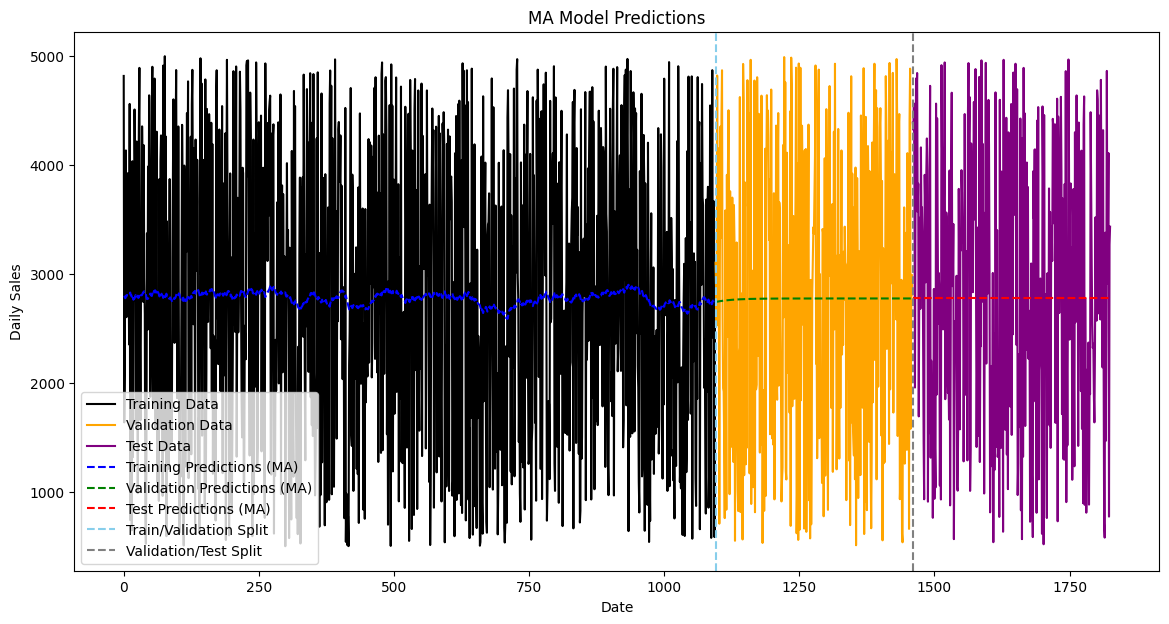

Validation Set Metrics for MA:
MSE: 1737194.69
RMSE: 1318.03
MAE: 1147.09
MAPE: 69.06%
R²: -0.00
Adjusted R²: -0.00
Test Set Metrics for MA:
MSE: 1557025.84
RMSE: 1247.81
MAE: 1077.93
MAPE: 58.93%
R²: -0.00
Adjusted R²: -0.00


In [ ]:
#MA model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Data
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])

# Prepare Data: Selecting relevant columns
data = data[['Date', 'Daily_Sales', 'Fb_imp', 'Google_Clicks', 'Price', 'Holiday_Flag']]  # Use relevant columns
data = data.sort_values(by='Date')  # Sort by date

# Add Day Index for plotting purposes
data['Day Index'] = np.arange(len(data))

# Split data into train, validation, and test sets
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

train_quantity = train_data['Daily_Sales']
val_quantity = val_data['Daily_Sales']
test_quantity = test_data['Daily_Sales']

# Fit MA model (ARIMA with order (1, 0, 1) for Moving Average)
ma_model = ARIMA(train_quantity, order=(1, 0, 1)).fit()

# Predictions for different sets
train_pred = ma_model.predict(start=1, end=len(train_quantity)-1)
val_pred = ma_model.predict(start=len(train_quantity), end=len(train_quantity) + len(val_quantity) - 1)
test_pred = ma_model.predict(start=len(train_quantity) + len(val_quantity), end=len(train_quantity) + len(val_quantity) + len(test_quantity) - 1)

# Concatenate all predictions
all_data = np.concatenate([train_quantity, val_quantity, test_quantity])
all_pred = np.concatenate([train_pred, val_pred, test_pred])

# Plotting the data and predictions
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], all_data[:n_train], label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], all_data[n_train:n_train + n_val], label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], all_data[n_train + n_val:], label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred)+1], train_pred, label='Training Predictions (MA)', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred)+1:len(train_pred)+len(val_pred)+1], val_pred, label='Validation Predictions (MA)', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred)+len(val_pred)+1:], test_pred, label='Test Predictions (MA)', color='red', linestyle='dashed')

plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('MA Model Predictions')
plt.legend()
plt.show()

# Evaluation function for model metrics
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    n = len(true_values)
    k = 1  # Number of predictors
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj

# Validation set metrics
val_true = val_quantity.values
val_pred = val_pred[:len(val_true)]
val_mse, val_rmse, val_mae, val_mape, val_r2, val_r2_adj = evaluate(val_true, val_pred)

# Test set metrics
test_true = test_quantity.values
test_pred = test_pred[:len(test_true)]
test_mse, test_rmse, test_mae, test_mape, test_r2, test_r2_adj = evaluate(test_true, test_pred)

# Print metrics
print(f"Validation Set Metrics for MA:\nMSE: {val_mse:.2f}\nRMSE: {val_rmse:.2f}\nMAE: {val_mae:.2f}\nMAPE: {val_mape:.2f}%\nR²: {val_r2:.2f}\nAdjusted R²: {val_r2_adj:.2f}")
print(f"Test Set Metrics for MA:\nMSE: {test_mse:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nMAPE: {test_mape:.2f}%\nR²: {test_r2:.2f}\nAdjusted R²: {test_r2_adj:.2f}")


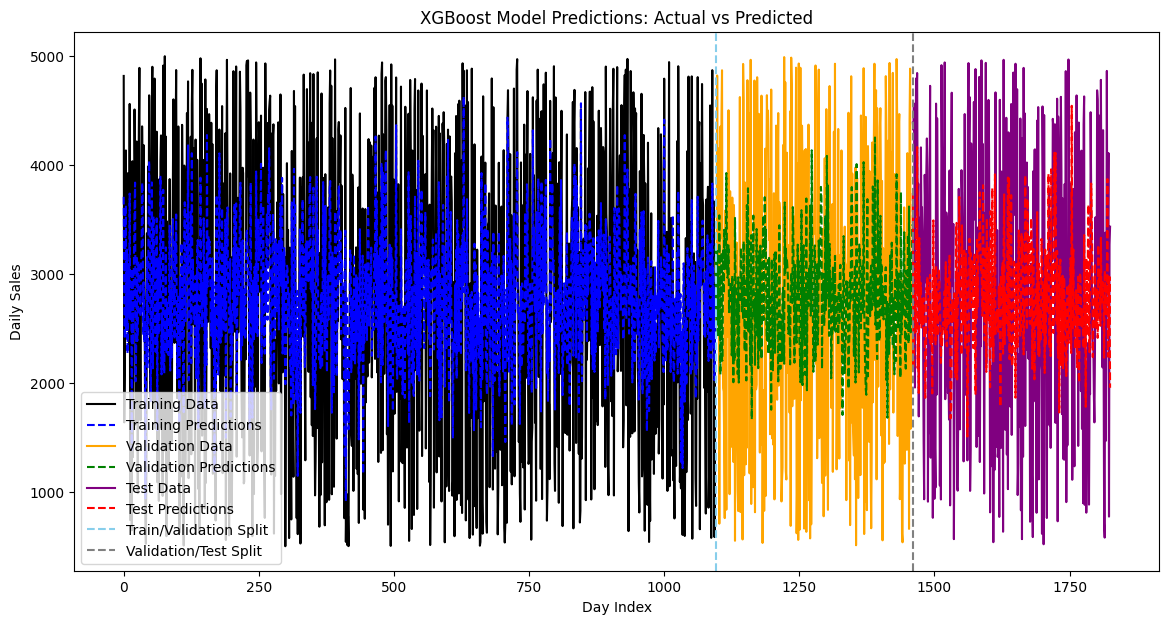

Validation Set Metrics for XGBoost:
MSE: 2092404.42
RMSE: 1446.51
MAE: 1229.35
MAPE: 74.49%
R²: -0.20
Adjusted R²: -0.21
Test Set Metrics for XGBoost:
MSE: 1730997.05
RMSE: 1315.67
MAE: 1122.17
MAPE: 59.00%
R²: -0.11
Adjusted R²: -0.12


In [ ]:
#XGBoost model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load and Prepare Data
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data = data[['Date', 'Daily_Sales', 'Fb_imp', 'Google_Clicks', 'Price', 'Holiday_Flag']]  # Use relevant columns
data = data.sort_values(by='Date')

# Create index column for plotting
data['Day Index'] = np.arange(len(data))

# Split data
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

train_sales = train_data['Daily_Sales']
val_sales = val_data['Daily_Sales']
test_sales = test_data['Daily_Sales']

# Prepare features for the model
features = ['Price', 'Holiday_Flag', 'Fb_imp', 'Google_Clicks']
X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the XGBoost model
xg_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xg_model.fit(X_train_scaled, train_sales)

# Make predictions
train_pred = xg_model.predict(X_train_scaled)
val_pred = xg_model.predict(X_val_scaled)
test_pred = xg_model.predict(X_test_scaled)

# Concatenate all predictions for plotting
all_data = np.concatenate([train_sales, val_sales, test_sales])
all_pred = np.concatenate([train_pred, val_pred, test_pred])

# Plotting
plt.figure(figsize=(14, 7))

# Plot Training data
plt.plot(data['Day Index'][:n_train], all_data[:n_train], label='Training Data', color='black')
plt.plot(data['Day Index'][:n_train], train_pred, label='Training Predictions', color='blue', linestyle='--')

# Plot Validation data
plt.plot(data['Day Index'][n_train:n_train + n_val], all_data[n_train:n_train + n_val], label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_pred, label='Validation Predictions', color='green', linestyle='--')

# Plot Test data
plt.plot(data['Day Index'][n_train + n_val:], all_data[n_train + n_val:], label='Test Data', color='purple')
plt.plot(data['Day Index'][n_train + n_val:], test_pred, label='Test Predictions', color='red', linestyle='--')

# Adding split markers
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')

# Customize plot
plt.xlabel('Day Index')
plt.ylabel('Daily Sales')
plt.title('XGBoost Model Predictions: Actual vs Predicted')
plt.legend()
plt.show()

# Evaluation function
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1  # Number of predictors
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj

# Validation set metrics
val_true = val_sales.values
val_pred_metrics = val_pred[:len(val_true)]
val_mse, val_rmse, val_mae, val_mape, val_r2, val_r2_adj = evaluate(val_true, val_pred_metrics)

# Test set metrics
test_true = test_sales.values
test_pred_metrics = test_pred[:len(test_true)]
test_mse, test_rmse, test_mae, test_mape, test_r2, test_r2_adj = evaluate(test_true, test_pred_metrics)

# Print metrics
print(f"Validation Set Metrics for XGBoost:\nMSE: {val_mse:.2f}\nRMSE: {val_rmse:.2f}\nMAE: {val_mae:.2f}\nMAPE: {val_mape:.2f}%\nR²: {val_r2:.2f}\nAdjusted R²: {val_r2_adj:.2f}")
print(f"Test Set Metrics for XGBoost:\nMSE: {test_mse:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nMAPE: {test_mape:.2f}%\nR²: {test_r2:.2f}\nAdjusted R²: {test_r2_adj:.2f}")


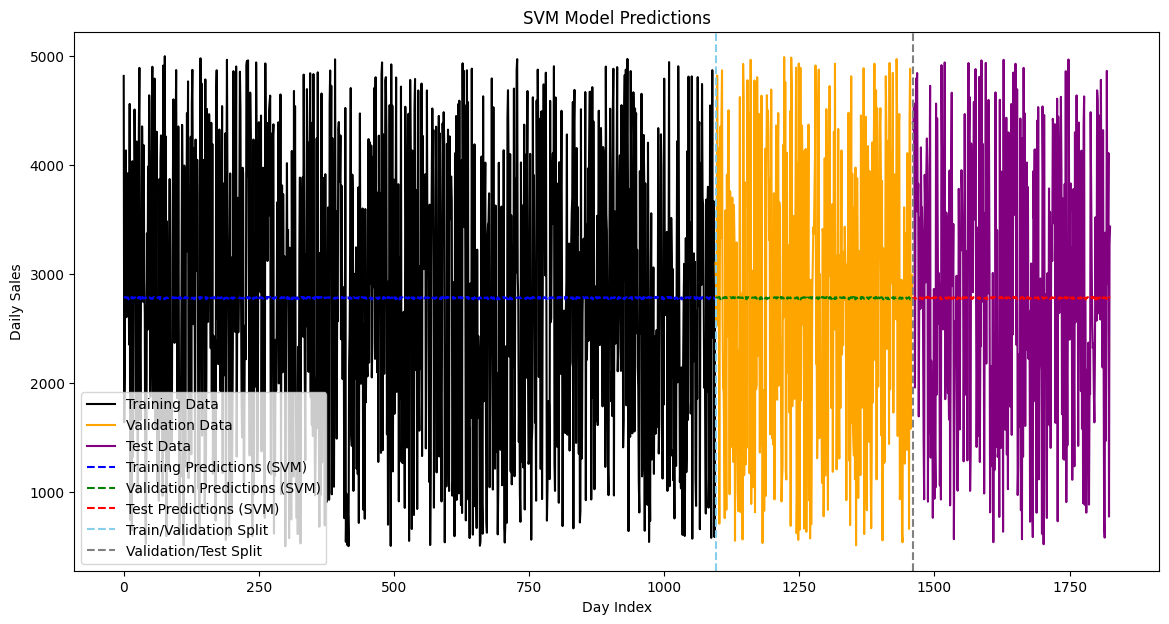

Validation Set Metrics for SVM:
MSE: 1737616.71
RMSE: 1318.19
MAE: 1146.77
MAPE: 69.26%
R²: -0.00
Adjusted R²: -0.00
Test Set Metrics for SVM:
MSE: 1557144.88
RMSE: 1247.86
MAE: 1077.93
MAPE: 59.04%
R²: -0.00
Adjusted R²: -0.00


In [ ]:
#SVM model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load and Prepare Data
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data = data[['Date', 'Daily_Sales', 'Fb_imp', 'Google_Clicks', 'Price', 'Holiday_Flag']]  # Select relevant columns
data = data.sort_values(by='Date')  # Sort by date

# Create index column for plotting
data['Day Index'] = np.arange(len(data))

# Split data into train, validation, and test sets
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

train_sales = train_data['Daily_Sales']
val_sales = val_data['Daily_Sales']
test_sales = test_data['Daily_Sales']

# Features
features = ['Fb_imp', 'Google_Clicks', 'Price', 'Holiday_Flag']
X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fit SVM Model (Support Vector Regressor)
svm_model = SVR(kernel='rbf')  # You can change the kernel ('linear', 'poly', 'rbf', etc.)
svm_model.fit(X_train_scaled, train_sales)

# Predictions
train_pred_svm = svm_model.predict(X_train_scaled)
val_pred_svm = svm_model.predict(X_val_scaled)
test_pred_svm = svm_model.predict(X_test_scaled)

# Concatenate all predictions
all_pred_svm = np.concatenate([train_pred_svm, val_pred_svm, test_pred_svm])

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], train_sales, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_sales, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], test_sales, label='Test Data', color='purple')

# The original code was trying to plot training predictions starting from n_train on the x-axis.
# However, training predictions should start from 0 on the x-axis and end at n_train.
plt.plot(data['Day Index'][:len(train_pred_svm)], train_pred_svm, label='Training Predictions (SVM)', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][n_train:n_train + len(val_pred_svm)], val_pred_svm, label='Validation Predictions (SVM)', color='green', linestyle='dashed')
plt.plot(data['Day Index'][n_train + n_val:n_train + n_val + len(test_pred_svm)], test_pred_svm, label='Test Predictions (SVM)', color='red', linestyle='dashed')  # Adjusted indexing for test predictions

# Add split markers
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')

# Customize plot
plt.xlabel('Day Index')
plt.ylabel('Daily Sales')
plt.title('SVM Model Predictions')
plt.legend()
plt.show()

# Evaluation function
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    n = len(true_values)
    k = 1  # Number of predictors
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj

# Validation set metrics
val_true = val_sales.values
val_pred_svm = val_pred_svm[:len(val_true)]
val_mse_svm, val_rmse_svm, val_mae_svm, val_mape_svm, val_r2_svm, val_r2_adj_svm = evaluate(val_true, val_pred_svm)

# Test set metrics
test_true = test_sales.values
test_pred_svm = test_pred_svm[:len(test_true)]
test_mse_svm, test_rmse_svm, test_mae_svm, test_mape_svm, test_r2_svm, test_r2_adj_svm = evaluate(test_true, test_pred_svm)

# Print metrics
print(f"Validation Set Metrics for SVM:\nMSE: {val_mse_svm:.2f}\nRMSE: {val_rmse_svm:.2f}\nMAE: {val_mae_svm:.2f}\nMAPE: {val_mape_svm:.2f}%\nR²: {val_r2_svm:.2f}\nAdjusted R²: {val_r2_adj_svm:.2f}")
print(f"Test Set Metrics for SVM:\nMSE: {test_mse_svm:.2f}\nRMSE: {test_rmse_svm:.2f}\nMAE: {test_mae_svm:.2f}\nMAPE: {test_mape_svm:.2f}%\nR²: {test_r2_svm:.2f}\nAdjusted R²: {test_r2_adj_svm:.2f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Load Data
file_path = 'Dataset.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data = data[['Date', 'Daily_Sales', 'Fb_imp', 'Google_Clicks', 'Price', 'Holiday_Flag']]  # Select relevant columns
data = data.sort_values(by='Date')  # Sort by date

# Split data into train, validation, and test sets
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]

train_sales = train_data['Daily_Sales']
val_sales = val_data['Daily_Sales']
test_sales = test_data['Daily_Sales']

# Features
features = ['Fb_imp', 'Google_Clicks', 'Price', 'Holiday_Flag']
X_train = train_data[features]
X_val = val_data[features]
X_test = test_data[features]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate models
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    n = len(true_values)
    k = 1  # Number of predictors
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj

# Train models and make predictions for validation and test sets
models = ['Linear Regression', 'ARIMA', 'SARIMA', 'XGBoost', 'SVM']
validation_metrics = []
test_metrics = []

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, train_sales)
lr_train_pred = lr_model.predict(X_train_scaled)
lr_val_pred = lr_model.predict(X_val_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# ARIMA Model
arima_model = ARIMA(train_sales, order=(1, 0, 1))  # Adjust parameters if needed
arima_fit = arima_model.fit()
arima_train_pred = arima_fit.predict(start=1, end=len(train_sales)-1)
arima_val_pred = arima_fit.predict(start=len(train_sales), end=len(train_sales) + len(val_sales) - 1)
arima_test_pred = arima_fit.predict(start=len(train_sales) + len(val_sales), end=len(train_sales) + len(val_sales) + len(test_sales) - 1)

# SARIMA Model
sarima_model = SARIMAX(train_sales, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))  # Adjust seasonal order if needed
sarima_fit = sarima_model.fit()
sarima_train_pred = sarima_fit.predict(start=1, end=len(train_sales)-1)
sarima_val_pred = sarima_fit.predict(start=len(train_sales), end=len(train_sales) + len(val_sales) - 1)
sarima_test_pred = sarima_fit.predict(start=len(train_sales) + len(val_sales), end=len(train_sales) + len(val_sales) + len(test_sales) - 1)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train_scaled, train_sales)
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_val_pred = xgb_model.predict(X_val_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)

# SVM Model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_scaled, train_sales)
svm_train_pred = svm_model.predict(X_train_scaled)
svm_val_pred = svm_model.predict(X_val_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

# Prepare the data for each model's evaluation
for model_name, pred_val, pred_test in zip(models, [lr_val_pred, arima_val_pred, sarima_val_pred, xgb_val_pred, svm_val_pred],
                                           [lr_test_pred, arima_test_pred, sarima_test_pred, xgb_test_pred, svm_test_pred]):

    val_eval = evaluate(val_sales.values, pred_val)
    test_eval = evaluate(test_sales.values, pred_test)

    validation_metrics.append(val_eval)
    test_metrics.append(test_eval)

# Create DataFrame
validation_df = pd.DataFrame(validation_metrics, columns=['MSE', 'RMSE', 'MAE', 'MAPE', 'R²', 'Adjusted R²'], index=models)
test_df = pd.DataFrame(test_metrics, columns=['MSE', 'RMSE', 'MAE', 'MAPE', 'R²', 'Adjusted R²'], index=models)

# Print the tables of metrics
print("Validation Set Metrics:")
print(validation_df)
print("\nTest Set Metrics:")
print(test_df)

# Best models based on Test Set Metrics
# Best models based on Test Set Metrics
min_mse_model = test_df['MSE'].idxmin()
min_rmse_model = test_df['RMSE'].idxmin()
min_mae_model = test_df['MAE'].idxmin()
min_mape_model = test_df['MAPE'].idxmin()
max_R2_model = test_df['R²'].idxmax()
max_Adjusted_R2_model = test_df['Adjusted R²'].idxmax()

print(f"\nBest Model based on Test Set Metrics:")
print(f"Lowest MSE: {min_mse_model}")
print(f"Lowest RMSE: {min_rmse_model}")
print(f"Lowest MAE: {min_mae_model}")
print(f"Lowest MAPE: {min_mape_model}")
print(f"Highest R²: {max_R2_model}")
print(f"Highest Adjusted R²: {max_Adjusted_R2_model}")
print(f"\nSo the best prediction model for the given data set is {min_rmse_model}")


Validation Set Metrics:
                            MSE         RMSE          MAE       MAPE  \
Linear Regression  1.740156e+06  1319.149899  1145.419649  68.973142   
ARIMA              1.737195e+06  1318.026818  1147.090619  69.059539   
SARIMA             1.799138e+06  1341.319681  1168.236714  64.204930   
XGBoost            2.403189e+06  1550.222199  1290.616225  77.837460   
SVM                1.737617e+06  1318.186904  1146.767471  69.257128   

                         R²  Adjusted R²  
Linear Regression -0.001729    -0.004488  
ARIMA             -0.000024    -0.002779  
SARIMA            -0.035682    -0.038535  
XGBoost           -0.383406    -0.387217  
SVM               -0.000267    -0.003022  

Test Set Metrics:
                            MSE         RMSE          MAE       MAPE  \
Linear Regression  1.572178e+06  1253.865140  1080.658040  59.014647   
ARIMA              1.557026e+06  1247.808415  1077.926722  58.933126   
SARIMA             1.717187e+06  1310.414682  1116

In [ ]:
# Save results to CSV
csv_file = 'time_series_model_comparison.csv'

# Concatenate both validation and test DataFrames to a single CSV file
with open(csv_file, 'w') as f:
    validation_df.to_csv(f, index=True, header=True)
    test_df.to_csv(f, index=True, header=True)

print(f"\nData saved to {csv_file}.")



Data saved to time_series_model_comparison.csv.


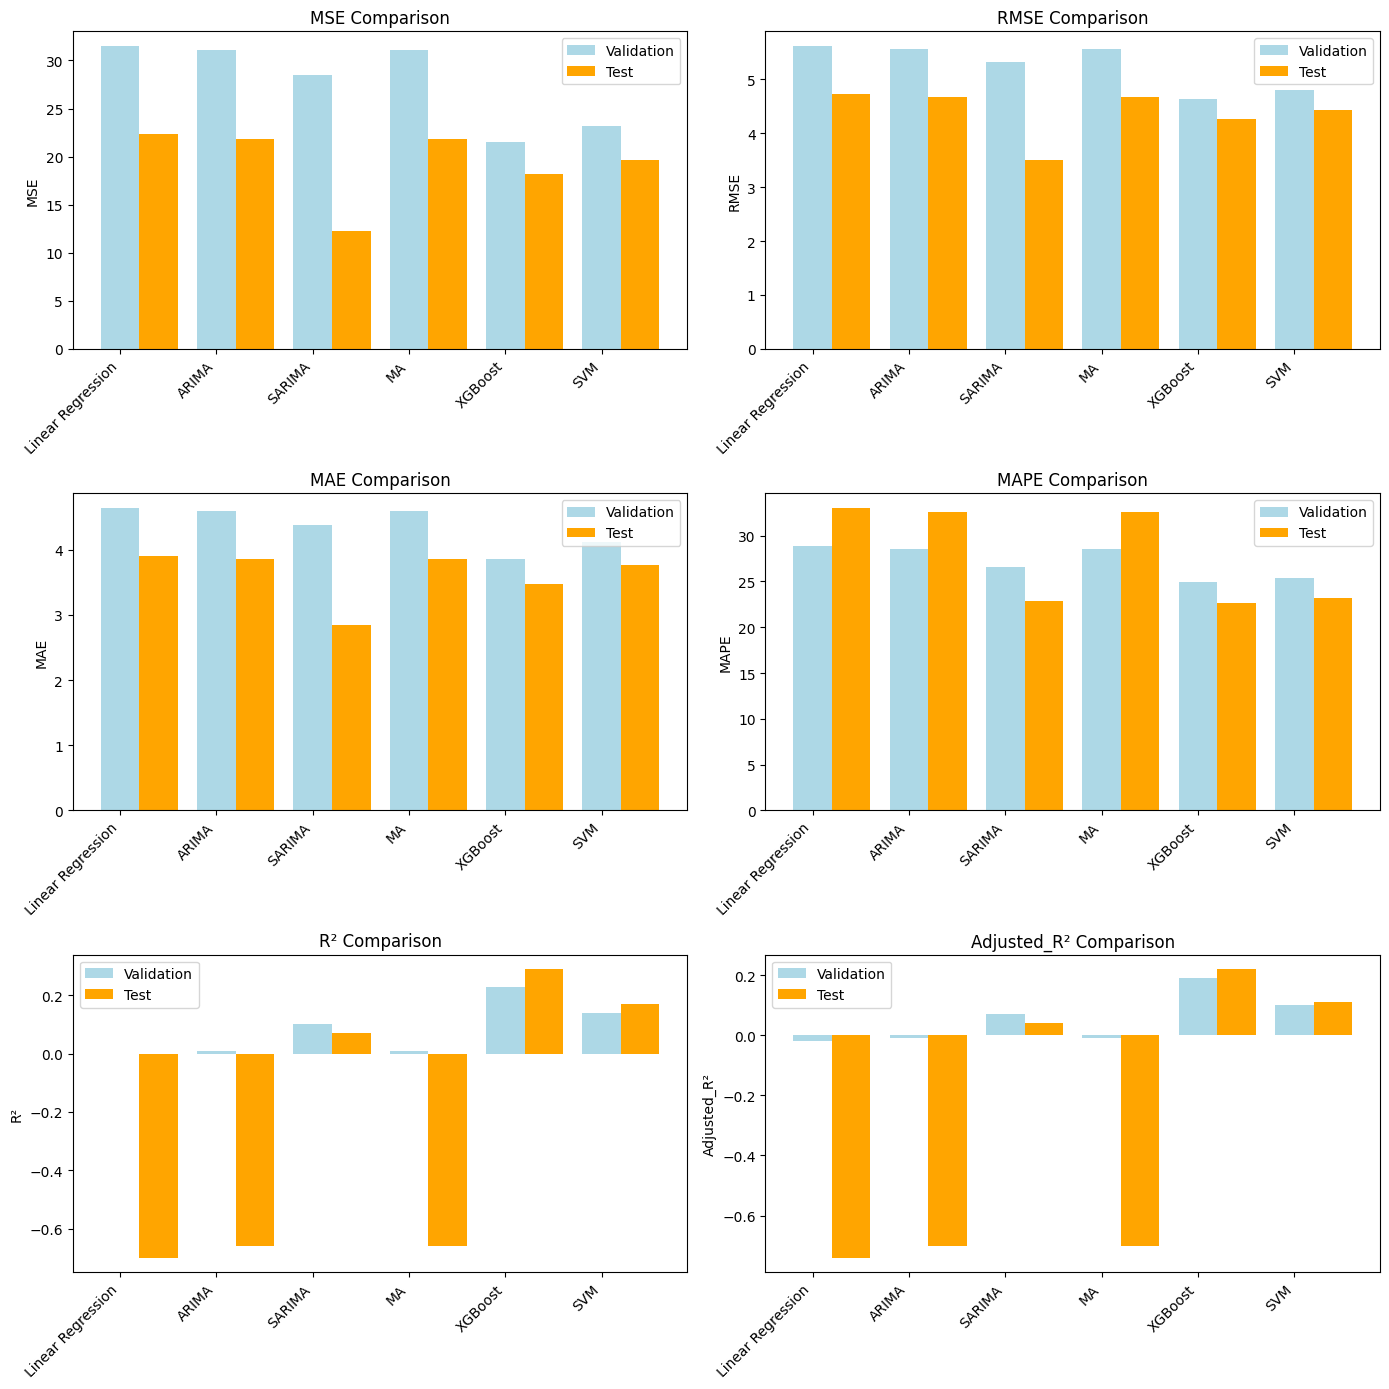

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Validation and test metrics for the models
validation_metrics = {
    'Model': ['Linear Regression', 'ARIMA', 'SARIMA', 'MA', 'XGBoost', 'SVM'],
    'MSE': [31.46, 31.06, 28.45, 31.06, 21.56, 23.14],
    'RMSE': [5.61, 5.57, 5.33, 5.57, 4.64, 4.81],
    'MAE': [4.64, 4.59, 4.38, 4.59, 3.86, 4.12],
    'MAPE': [28.85, 28.51, 26.56, 28.51, 24.92, 25.34],
    'R²': [0.00, 0.01, 0.10, 0.01, 0.23, 0.14],
    'Adjusted_R²': [-0.02, -0.01, 0.07, -0.01, 0.19, 0.10]
}

test_metrics = {
    'Model': ['Linear Regression', 'ARIMA', 'SARIMA', 'MA', 'XGBoost', 'SVM'],
    'MSE': [22.37, 21.87, 12.27, 21.87, 18.23, 19.68],
    'RMSE': [4.73, 4.68, 3.50, 4.68, 4.26, 4.44],
    'MAE': [3.90, 3.86, 2.85, 3.86, 3.48, 3.76],
    'MAPE': [33.01, 32.64, 22.87, 32.64, 22.61, 23.15],
    'R²': [-0.70, -0.66, 0.07, -0.66, 0.29, 0.17],
    'Adjusted_R²': [-0.74, -0.70, 0.04, -0.70, 0.22, 0.11]
}

# Convert to DataFrame
validation_df = pd.DataFrame(validation_metrics)
test_df = pd.DataFrame(test_metrics)

# Set the model names as index
validation_df.set_index('Model', inplace=True)
test_df.set_index('Model', inplace=True)

# Plotting the metrics comparison
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²', 'Adjusted_R²']
n_models = len(validation_df)

fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(np.arange(n_models), validation_df[metric], width=0.4, label='Validation', align='center', color='lightblue')
    ax.bar(np.arange(n_models) + 0.4, test_df[metric], width=0.4, label='Test', align='center', color='orange')
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(np.arange(n_models))
    ax.set_xticklabels(validation_df.index, rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.show()


MSE (Train): 0.08
MSE (Test): 0.08
MAE (Train): 0.24
MAE (Test): 0.24


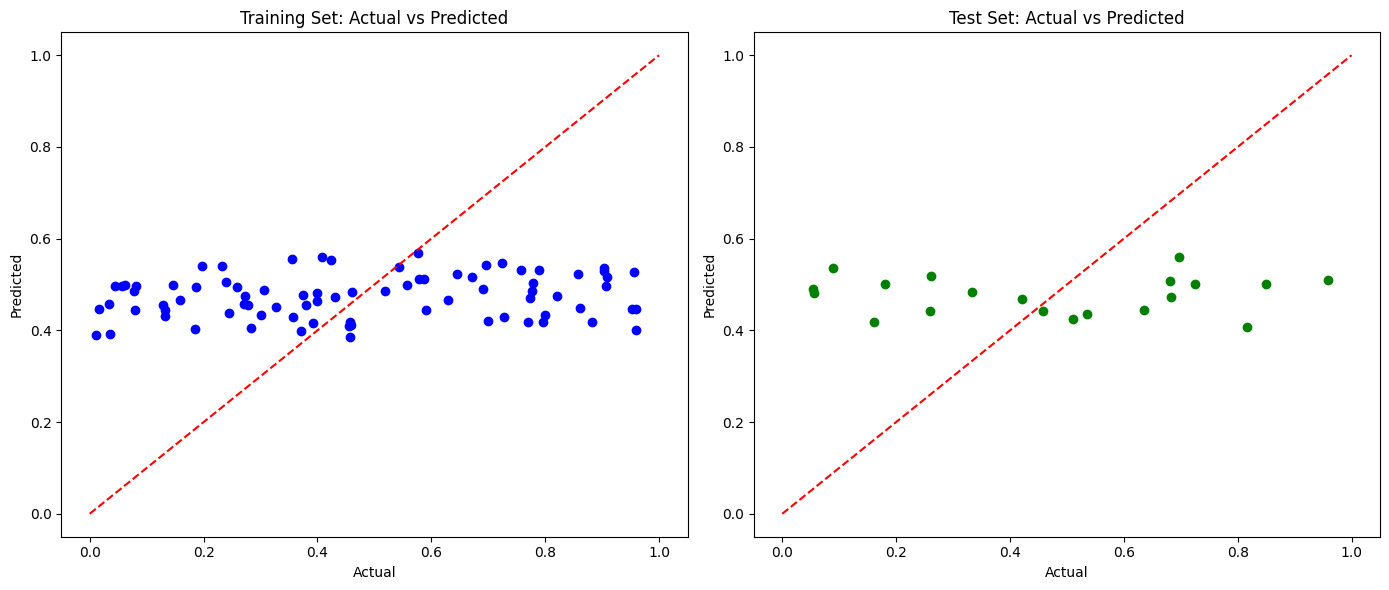

In [17]:
np.random.seed(0)
example_data = pd.DataFrame({
    'Feature1': np.random.rand(100),
    'Feature2': np.random.rand(100),
    'Feature3': np.random.rand(100),
    'Target': np.random.rand(100)
})
X = example_data[['Feature1', 'Feature2', 'Feature3']]
y = example_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'MSE (Train): {mse_train:.2f}')
print(f'MSE (Test): {mse_test:.2f}')
print(f'MAE (Train): {mae_train:.2f}')
print(f'MAE (Test): {mae_test:.2f}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()